## Модель отбора коров для молочного хозяйства "Вольный луг"

В рамках проекта разрабатывается две прогнозные модели машинного обучения для фермера, владельца молочного хозяйства, с целью оптимизации отбора бурёнок. Первая модель прогнозирует удой коровы, а вторая оценивает вероятность получения вкусного молока от коровы. Задачи проекта включают в себя создание точных прогнозов для управления рисками, а также отбор коров с удовлетворительными характеристиками, такими как средний удой не менее 6000 кг в год и вкусное молоко согласно критериям фермера. Ожидаемые результаты включают повышение эффективности поголовья коров и обеспечение фермеру возможности принимать обоснованные решения о покупке коров для расширения своего молочного хозяйства.


## Загрузка данных

Загрузите данные в датафреймы pandas. Файлы можно скачать по ссылкам в описании, они даже доступны через пути:
    /datasets/ferma_main.csv
    /datasets/ferma_dad.csv
    /datasets/cow_buy.csv

Изучите данные. Определите, соответствуют ли они описанию задачи и изученным в прошлых спринтах стандартам оформления данных. При необходимости переименуйте столбцы.

In [1]:
! pip install -q phik

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
import phik
import warnings
warnings.filterwarnings('ignore')

In [3]:
farm_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
farm_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

In [4]:
farm_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [5]:
farm_main = farm_main.rename(
    columns={'Удой, кг': 'yield_kg', 'ЭКЕ (Энергетическая кормовая единица)': 'EFU',
             'Сырой протеин, г': 'raw_protein_g', 'СПО (Сахаро-протеиновое соотношение)':'SPR',
             'Порода':'breed', 'Тип пастбища': 'pasture_type', 'порода папы_быка': 'dad_bull_breed',
             'Жирность,%': 'fat_content', 'Белок,%':'protein', 'Вкус молока':'taste', 'Возраст':'age'})

In [6]:
farm_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              634 non-null    int64  
 1   yield_kg        634 non-null    int64  
 2   EFU             634 non-null    float64
 3   raw_protein_g   634 non-null    int64  
 4   SPR             634 non-null    float64
 5   breed           634 non-null    object 
 6   pasture_type    634 non-null    object 
 7   dad_bull_breed  634 non-null    object 
 8   fat_content     634 non-null    float64
 9   protein         634 non-null    float64
 10  taste           634 non-null    object 
 11  age             634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [7]:
farm_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [8]:
farm_dad = farm_dad.rename( columns={'Имя Папы': 'dad_bull_name'})

In [9]:
farm_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             629 non-null    int64 
 1   dad_bull_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [10]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [11]:
cow_buy = cow_buy.rename(
    columns={'Порода': 'breed','Тип пастбища': 'pasture_type', 'порода папы_быка': 'dad_bull_breed',
             'Имя_папы': 'dad_bull_name', 'Текущая_жирность,%': 'fat_content', 'Текущий_уровень_белок,%':'protein', 
             'Возраст':'age'})

In [12]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   breed           20 non-null     object 
 1   pasture_type    20 non-null     object 
 2   dad_bull_breed  20 non-null     object 
 3   dad_bull_name   20 non-null     object 
 4   fat_content     20 non-null     float64
 5   protein         20 non-null     float64
 6   age             20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


**Файл ferma_main.csv содержит данные о стаде фермера на текущий момент.**

1. Признаки и их описание:
* `id` — уникальный идентификатор коровы.
* `yield_kg`, Удой, кг — масса молока, которую корова даёт в год (в килограммах).
* `EFU`, ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
* `raw_protein_g`, Сырой протеин, г — содержание сырого протеина в корме (в граммах).
* `SPR`, СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
* `breed`, Порода — порода коровы.
* `pasture_type`, Тип пастбища — ландшафт лугов, на которых паслась корова.
* `dad_bull_breed` порода папы_быка — порода папы коровы.
* `fat_content`, Жирность,% — содержание жиров в молоке (в процентах).
* `protein`, Белок,% — содержание белков в молоке (в процентах).
* `taste`, Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
* `age`, Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
2. Размеры и другие особенности:
* Количество записей: 634.
* Количество признаков: 12.
* Присутствуют различные типы данных, включая целочисленные, числовые с плавающей точкой и категориальные (object).

*Признаки в датасете ferma_main.csv можно разделить на группы.*

* Характеристики коровы: id, Порода, порода папы_быка, Возраст.
* Характеристики корма: ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г, СПО (Сахаро-протеиновое соотношение).
* Характеристика пастбища: Тип пастбища.
* Характеристики молока: Удой, кг, Жирность,%, Белок,%, Вкус молока.


**Файл ferma_dad.csv хранит имя папы каждой коровы в стаде фермера.** 
1. Признаки и их описание:
* `id` — уникальный идентификатор коровы.
* `dad_bull_name` Имя Папы — имя папы коровы.
2. Размеры и другие особенности:
* Количество записей: 629.
* Количество признаков: 2.
* Присутствуют целочисленные и категориальные (object) типы данных.

**Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.** 
1. Признаки и их описание:
* `breed`, Порода — порода коровы.
* `pasture_type`, Тип пастбища — ландшафт лугов, на которых паслась корова.
* `dad_bull_breed`, порода папы_быка — порода папы коровы.
* `dad_bull_name`, Имя_папы — имя папы коровы.
* `fat_content_curr`, Текущая_жирность,% — содержание жиров в молоке (в процентах).
* `protein_curr`, Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
* `age`, Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).
2. Размеры и другие особенности:
* Количество записей: 20.
* Количество признаков: 7.
* Присутствуют как количественные, так и категориальные (object) типы данных.

Данные в файлах ferma_main.csv и cow_buy.csv похожи, но у датасета cow_buy.csv несколько особенностей.
Содержание белков и жиров в молоке указано на момент продажи — когда «ЭкоФерма» давала коровам свой корм.
Параметры корма ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%.
Кроме того, отсутствуют признаки Удой, кг и Вкус молока. Это целевые признаки, именно их предстоит предсказать!


    /datasets/ferma_main.csv
    /datasets/ferma_dad.csv
    /datasets/cow_buy.csv

##  Предобработка данных

Проверьте данные на наличие пропусков и дубликатов. Узнайте, корректны ли типы данных у каждого признака. При необходимости устраните все проблемы с данными.

In [13]:
farm_main.head()

,id,yield_kg,EFU,raw_protein_g,SPR,breed,pasture_type,dad_bull_breed,fat_content,protein,taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [14]:
farm_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              634 non-null    int64  
 1   yield_kg        634 non-null    int64  
 2   EFU             634 non-null    float64
 3   raw_protein_g   634 non-null    int64  
 4   SPR             634 non-null    float64
 5   breed           634 non-null    object 
 6   pasture_type    634 non-null    object 
 7   dad_bull_breed  634 non-null    object 
 8   fat_content     634 non-null    float64
 9   protein         634 non-null    float64
 10  taste           634 non-null    object 
 11  age             634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [15]:
farm_main.isna().sum()

id                0
yield_kg          0
EFU               0
raw_protein_g     0
SPR               0
breed             0
pasture_type      0
dad_bull_breed    0
fat_content       0
protein           0
taste             0
age               0
dtype: int64

In [16]:
farm_main.duplicated().sum()

5

In [17]:
farm_main[farm_main.duplicated()]

,id,yield_kg,EFU,raw_protein_g,SPR,breed,pasture_type,dad_bull_breed,fat_content,protein,taste,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [18]:
farm_main = farm_main.drop_duplicates()

In [19]:
farm_main['breed'].value_counts()

Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: breed, dtype: int64

In [20]:
farm_main.pasture_type.value_counts()

Холмистое    351
Равнинное    253
Равнинные     25
Name: pasture_type, dtype: int64

In [21]:
farm_main['pasture_type'] = farm_main['pasture_type'].replace({'Равнинные': 'Равнинное'})

In [22]:
farm_main.dad_bull_breed.value_counts()

Соверин    311
Айдиал     240
Айдиалл     78
Name: dad_bull_breed, dtype: int64

In [23]:
farm_main['dad_bull_breed'] = farm_main['dad_bull_breed'].replace({'Айдиалл': 'Айдиал'})

In [24]:
farm_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             629 non-null    int64 
 1   dad_bull_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [25]:
farm_dad.isna().sum()

id               0
dad_bull_name    0
dtype: int64

In [26]:
farm_dad.duplicated().sum()

0

In [27]:
farm_dad.dad_bull_name.value_counts()

Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: dad_bull_name, dtype: int64

In [28]:
cow_buy.head()

,breed,pasture_type,dad_bull_breed,dad_bull_name,fat_content,protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [29]:
cow_buy.isna().sum()

breed             0
pasture_type      0
dad_bull_breed    0
dad_bull_name     0
fat_content       0
protein           0
age               0
dtype: int64

In [30]:
cow_buy.duplicated().sum()

4

In [31]:
cow_buy[cow_buy.duplicated()]

,breed,pasture_type,dad_bull_breed,dad_bull_name,fat_content,protein,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [32]:
cow_buy['pasture_type'] = cow_buy['pasture_type'].replace({'холмистое': 'Холмистое'})
cow_buy['pasture_type'] = cow_buy['pasture_type'].replace({'равнинное': 'Равнинное'})
cow_buy.pasture_type.value_counts()

Равнинное    11
Холмистое     9
Name: pasture_type, dtype: int64

In [33]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   breed           20 non-null     object 
 1   pasture_type    20 non-null     object 
 2   dad_bull_breed  20 non-null     object 
 3   dad_bull_name   20 non-null     object 
 4   fat_content     20 non-null     float64
 5   protein         20 non-null     float64
 6   age             20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


В процессе предобработки данных в датасете `farm_main` выявлено отсутствие пропущенных значений. Однако обнаружено наличие 5 строк-дубликатов, которые успешно обработаны. Также были выявлены дубликаты в отдельных столбцах, таких как `pasture_type`, где присутствовали два варианта написания: "Равнинные" и "Равнинное", а также в столбце `dad_bull_breed` с двумя похожими значениями "Айдиал" и "Айдиалл".

Датасет `farm_dad` также оказался свободным от пропущенных значений, и дубликатов не обнаружено.

В отношении датасета `cow_buy` отмечено отсутствие пропусков, но выявлено 4 строки-дубликата, которые успешно обработаны в ходе предварительной обработки данных.

## Исследовательский анализ данных

Проведите статистический анализ всех признаков.

Постройте графики для каждого признака. Помните, что количественным и категориальным признакам подходят разные графики.

Сделайте выводы о данных:
напишите, заметили ли вы выбросы, необычное распределение количественных признаков или другие особенности;
расскажите, как вы планируете улучшить данные.

### farm_main.csv

In [34]:
farm_main.head()

,id,yield_kg,EFU,raw_protein_g,SPR,breed,pasture_type,dad_bull_breed,fat_content,protein,taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [35]:
farm_main.describe()

,id,yield_kg,EFU,raw_protein_g,SPR,fat_content,protein
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [36]:
(
    farm_main[['yield_kg', 'EFU', 'raw_protein_g', 'SPR', 'fat_content', 'protein']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,yield_kg,EFU,raw_protein_g,SPR,fat_content,protein
0.0012,"5,206.26",11.05,"1,660.75",0.84,2.99,3.07
0.01,"5,254.84",11.80,"1,664.00",0.84,3.11,3.07
0.5,"6,133.00",14.70,"1,888.00",0.93,3.65,3.08
0.99,"7,164.04",16.70,"2,337.44",0.95,3.74,3.08
0.9988,"16,682.28",16.80,"2,346.74",0.96,3.74,3.08


In [37]:
farm_main.shape[0]

629

<AxesSubplot:>

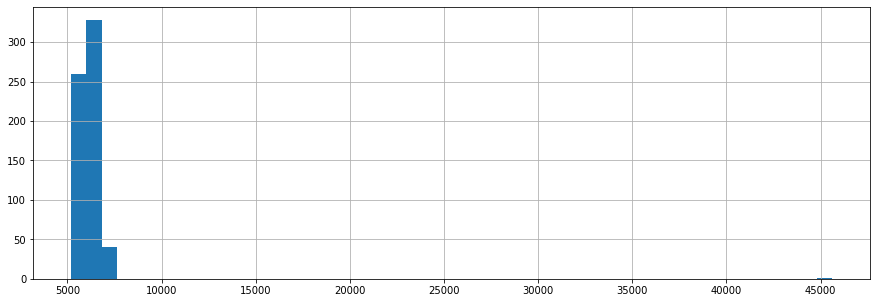

In [38]:
farm_main['yield_kg'].hist(bins=50, figsize=(15,5))

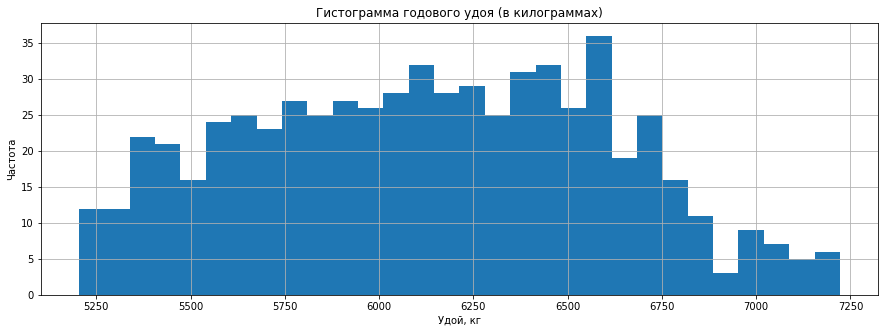

In [39]:
farm_main = farm_main.drop(farm_main[(farm_main['yield_kg'] > 7500)].index)
farm_main.yield_kg.hist(bins=30, figsize=(15,5))
plt.title('Гистограмма годового удоя (в килограммах)')
plt.xlabel('Удой, кг')
plt.ylabel('Частота')
plt.show()

Гистограмма годового удоя молока на ферме отображает, что средний удой составляет примерно 6126 кг, с разбросом значений от минимального (около 5204 кг) до максимального (7222 кг после удаления выбросов). Распределение похоже на нормальное с небольшой асимметрией и хвостами. Медиана близка к среднему значению, указывая на отсутствие значительного смещения. Большинство удоев сконцентрированы вокруг среднего значения, создавая пик в центре гистограммы. После удаления выбросов распределение стало более равномерным и компактным. 

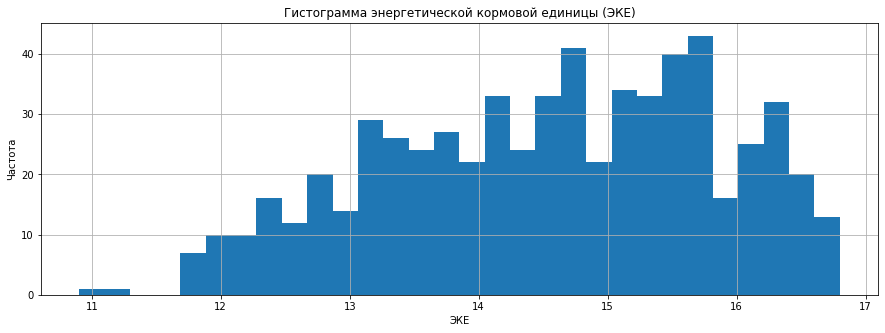

In [40]:
farm_main.EFU.hist(bins=30, figsize=(15,5))
plt.title('Гистограмма энергетической кормовой единицы (ЭКЕ)')
plt.xlabel('ЭКЕ')
plt.ylabel('Частота')
plt.show()

Гистограмма энергетической кормовой единицы (ЭКЕ) на ферме позволяет проанализировать распределение этого показателя. Среднее значение ЭКЕ составляет примерно 14.55, при стандартном отклонении в размере 1.30. Распределение выглядит относительно нормальным, с пиком в районе 14.7. Большинство значений сконцентрированы вокруг среднего, что создает компактную и симметричную форму гистограммы. Минимальное значение ЭКЕ составляет 10.9, максимальное - 16.8.

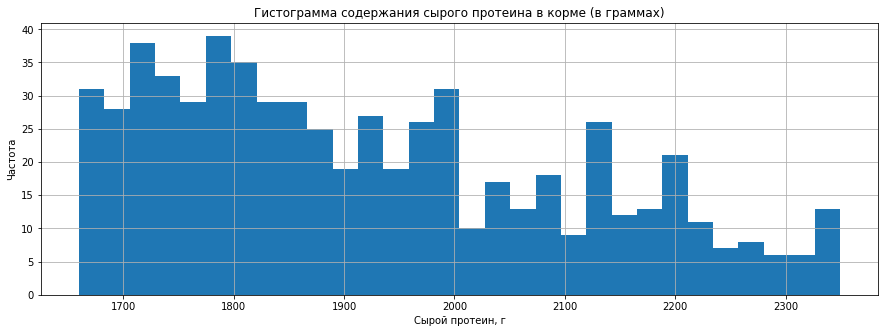

In [41]:
farm_main.raw_protein_g.hist(bins=30, figsize=(15,5))
plt.title('Гистограмма содержания сырого протеина в корме (в граммах)')
plt.xlabel('Сырой протеин, г')
plt.ylabel('Частота')
plt.show()

Форма гистограммы содержания сырого протеина в корме представляет собой приблизительно нормальное распределение с некоторым смещением вправо. Среднее значение составляет примерно 1923.76 г, а стандартное отклонение равно приблизительно 182.83 г. Гистограмма показывает, что большинство значений сосредоточены вокруг среднего значения.

Распределение имеет плавный пик в области среднего значения протеина, и оно охватывает диапазон от минимального значения в 1660 г до максимального значения в 2349 г. Примерно 25% данных находятся в интервале от минимального значения до 1771.75 г, 50% – от минимального до 1888 г, и 75% – от минимального до 2062.25 г.

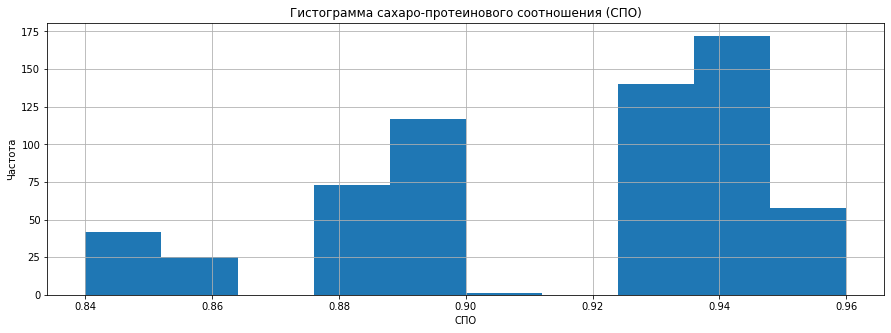

In [42]:
farm_main.SPR.hist(bins=10, figsize=(15,5))
plt.title('Гистограмма сахаро-протеинового соотношения (СПО)')
plt.xlabel('СПО')
plt.ylabel('Частота')
plt.show()

Гистограмма сахаро-протеинового соотношения (СПО) показывает, что распределение данных имеет форму, которая несколько скошена влево. Сахаро-протеиновое соотношение имеет среднее значение около 0.91, а стандартное отклонение составляет примерно 0.03. Большинство значений сосредоточено в области среднего значения.

Диапазон значений СПО на гистограмме варьируется от минимального значения в 0.84 до максимального в 0.96. Примерно 25% данных находятся в интервале от минимального значения до 0.89, 50% – от минимального до 0.93, и 75% – от минимального до 0.94.

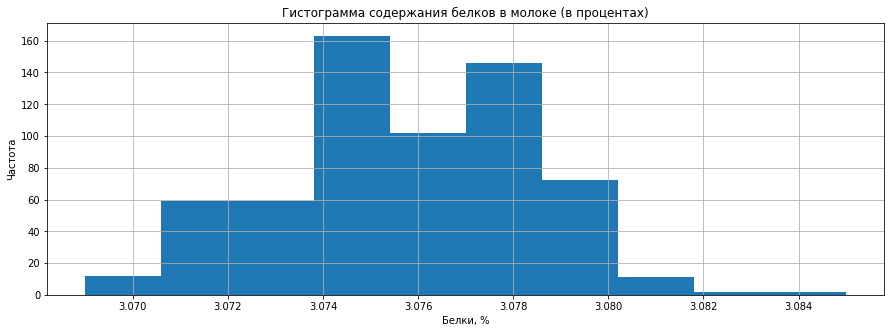

In [43]:
farm_main.protein.hist(bins=10, figsize=(15,5))
plt.title('Гистограмма содержания белков в молоке (в процентах)')
plt.xlabel('Белки, %')
plt.ylabel('Частота')
plt.show()

Гистограмма содержания белков в молоке показывает, что данные имеют узкое и высокое распределение. Среднее значение белков составляет примерно 3.08%, а стандартное отклонение – всего 0.00255. Большинство значений сосредоточено вокруг среднего значения. Диапазон значений содержания белков на гистограмме варьируется от минимального значения в 3.069% до максимального в 3.085%. Примерно 25% данных находятся в интервале от минимального значения до 3.074%, 50% – от минимального до 3.076%, и 75% – от минимального до 3.077%.

Гистограмма явно иллюстрирует узкое распределение содержания белков в молоке, что может быть характерно для данного набора данных.

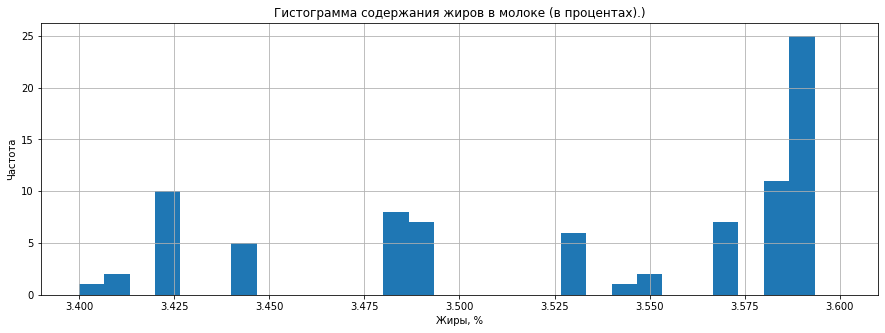

In [44]:
farm_main.fat_content.hist(bins=30, figsize=(15,5),range=(3.4,3.6))
plt.title('Гистограмма содержания жиров в молоке (в процентах).)')
plt.xlabel('Жиры, %')
plt.ylabel('Частота')
plt.show()

Гистограмма демонстрирует, что большинство образцов молока имеют относительно высокий процент содержания жиров, с пиком в районе 3.65%. Распределение асимметрично и смещено влево, что указывает на преобладание образцов с более высоким содержанием жиров. Однако разброс значений не является слишком широким, что может свидетельствовать о некоторой степени однородности в данных. Среднее значение (3.60%) и медиана (3.65%) находятся близко друг к другу, что также подчеркивает относительную симметрию распределения.

Таким образом, можно сказать, что в данной выборке молока преобладают образцы с умеренно высоким содержанием жиров, форма гистограммы указывает на отклонение от нормального распределения в сторону более высоких значений.

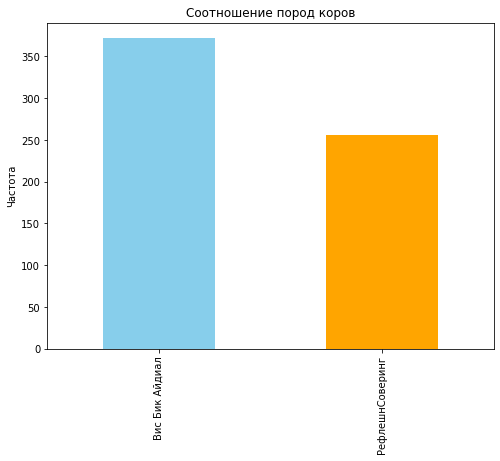

In [45]:
breed_counts = farm_main['breed'].value_counts()

plt.figure(figsize=(8, 6))
breed_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение пород коров')
plt.ylabel('Частота')
plt.show()

На графике видно, что существует две основные породы коров: "Вис Бик Айдиал" и "РефлешнСоверинг". Порода "Вис Бик Айдиал" преобладает, составляя значительное большинство общего числа коров в выборке, с частотой 372. В то время как порода "РефлешнСоверинг" имеет более низкую частоту, соответствующую 256 коровам.

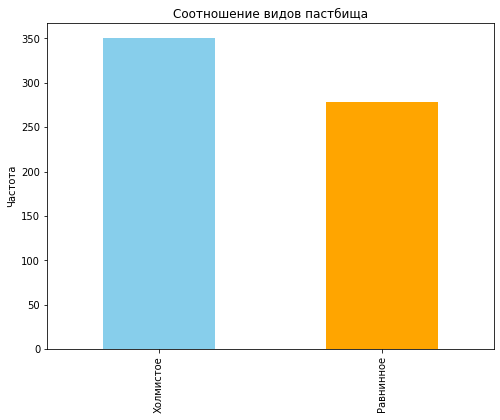

In [46]:
pasture_type_counts = farm_main['pasture_type'].value_counts()

plt.figure(figsize=(8, 6))
pasture_type_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение видов пастбища')
plt.ylabel('Частота')
plt.show()

График показывает, что есть два основных типа пастбищ: "Холмистое" и "Равнинное". Видно, что "Холмистое" пастбище имеет более высокую частоту, представленную 350 случаями, в то время как "Равнинное" пастбище имеет менее частое встречаемость, соответствующую 278 случаям.

Таким образом, в данной фермерской выборке представлены в основном два типа пастбищ, с преимущественным использованием "Холмистого" пастбища по сравнению с "Равнинным".

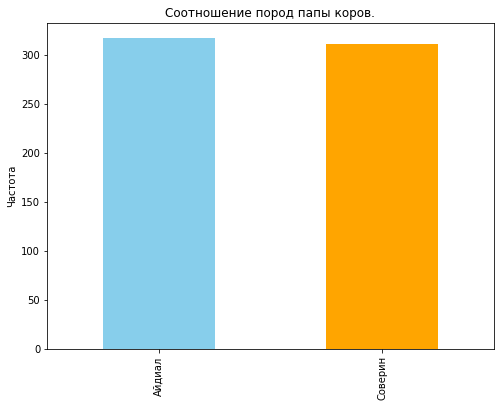

In [47]:
dad_bull_breed_counts = farm_main['dad_bull_breed'].value_counts()

plt.figure(figsize=(8, 6))
dad_bull_breed_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение пород папы коров.')
plt.ylabel('Частота')
plt.show()

График показывает, что существуют две основные породы отцов коров: "Айдиал" и "Соверин". Порода "Айдиал" имеет частоту 317 случаев, в то время как порода "Соверин" близка по частоте и составляет 311 случаев.

Таким образом, в данной фермерской выборке примерно равное количество коров, у которых отцы относятся к породам "Айдиал" и "Соверин".


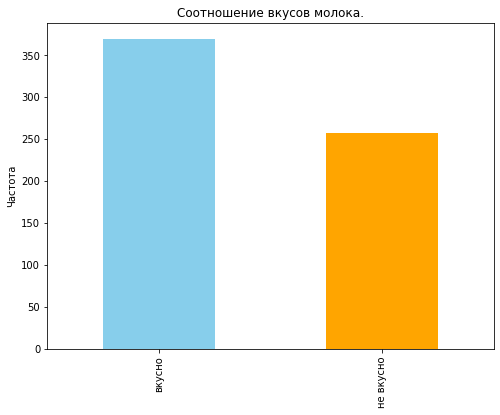

In [48]:
taste_counts = farm_main['taste'].value_counts()

plt.figure(figsize=(8, 6))
taste_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение вкусов молока.')
plt.ylabel('Частота')
plt.show()

Пропорция между 'вкусно' и 'невкусно': примерно три к четырем. Потенциально это может означать, что в данных может быть какой-то неучтенный перекос между группами.



Из гистограммы видно, что в выборке существует два основных вкусовых качества молока: "вкусно" и "не вкусно". График показывает, что большинство образцов молока (370 случаев) характеризуется как "вкусно", в то время как меньшее количество образцов (258 случаев) оценивается как "не вкусно".

Таким образом, в данной фермерской выборке преобладает положительное вкусовое качество молока, при этом отмечается менее значительное количество образцов с отрицательным вкусом.

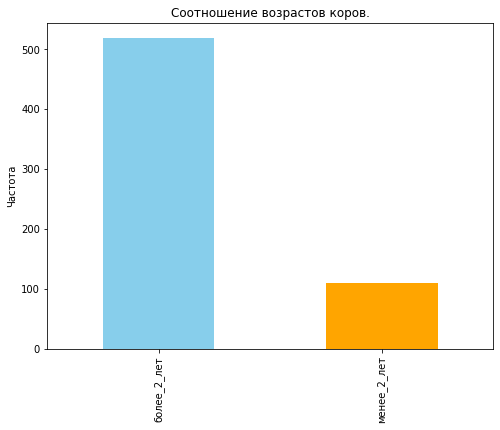

In [49]:
age_counts = farm_main['age'].value_counts()

plt.figure(figsize=(8, 6))
age_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение возрастов коров.')
plt.ylabel('Частота')
plt.show()

В выборке присутствуют коровы двух основных возрастных категорий: "более 2 лет" и "менее 2 лет". График показывает, что большинство коров (518 случаев) старше двух лет, в то время как меньшее количество коров (110 случаев) моложе двух лет.

Таким образом, в данной фермерской выборке преобладают коровы старше двух лет, а количество молодых коров (моложе двух лет) значительно меньше.

### farm_dad.csv

In [50]:
farm_dad.head()

,id,dad_bull_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


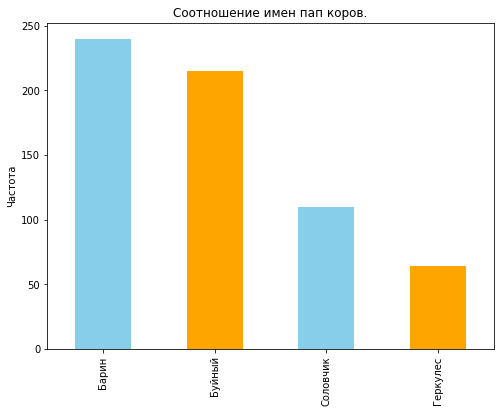

In [51]:
dad_bull_name_count = farm_dad['dad_bull_name'].value_counts()

plt.figure(figsize=(8, 6))
dad_bull_name_count.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение имен пап коров.')
plt.ylabel('Частота')
plt.show()

График показывает, что четыре основных имени пап коров: "Барин", "Буйный", "Соловчик" и "Геркулес". Имя "Барин" встречается наибольшее количество раз (240 случаев), за ним следуют "Буйный" (215 случаев), "Соловчик" (110 случаев) и "Геркулес" (64 случая).

Таким образом, в данной фермерской выборке можно выделить четыре основных имени отцов коров, причем "Барин" и "Буйный" являются более распространенными, чем "Соловчик" и "Геркулес".

### cow_buy.csv

In [52]:
cow_buy.head()

,breed,pasture_type,dad_bull_breed,dad_bull_name,fat_content,protein,age
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [53]:
cow_buy.describe()

,fat_content,protein
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


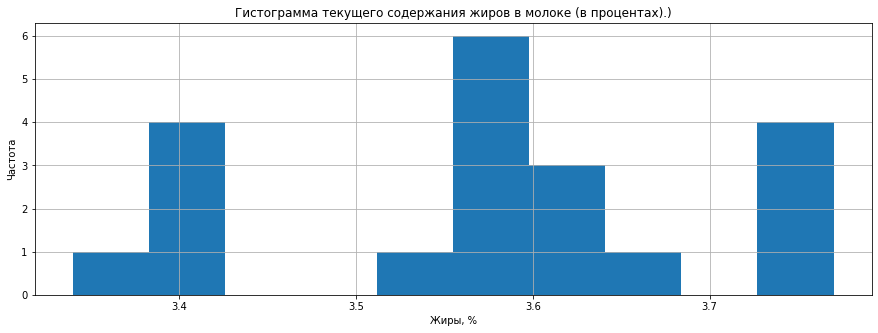

In [54]:
cow_buy.fat_content.hist(bins=10, figsize=(15,5))
plt.title('Гистограмма текущего содержания жиров в молоке (в процентах).)')
plt.xlabel('Жиры, %')
plt.ylabel('Частота')
plt.show()

Гистограмма демонстрирует, что большинство образцов молока имеют относительно узкий диапазон содержания жиров, с пиком в районе 3.59%. Распределение асимметрично и смещено вправо, что указывает на преобладание образцов с более низким содержанием жиров. Минимальное значение составляет 3.34%, максимальное - 3.77%. Среднее значение (3.58%) и медиана (3.59%) близки друг к другу, что подчеркивает относительную симметрию распределения.

Таким образом, в данной выборке текущее содержание жиров в молоке коров в основном концентрируется в узком диапазоне, с небольшими отклонениями от среднего значения.

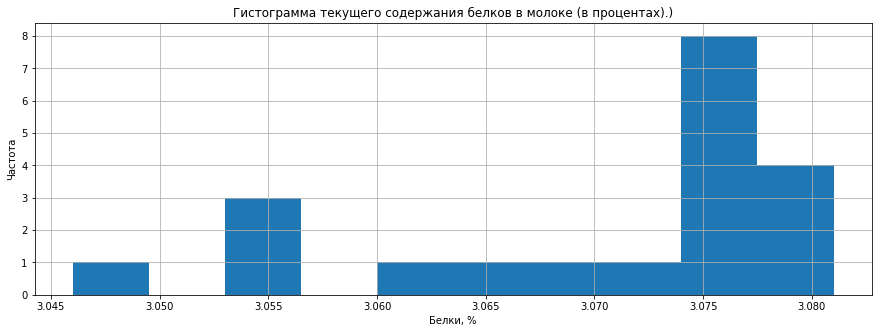

In [55]:
cow_buy.protein.hist(bins=10, figsize=(15,5))
plt.title('Гистограмма текущего содержания белков в молоке (в процентах).)')
plt.xlabel('Белки, %')
plt.ylabel('Частота')
plt.show()

Гистограмма показывает, что образцы молока имеют очень узкий диапазон содержания белков, с пиком в районе 3.074%. Распределение симметрично и достаточно узкое. Минимальное значение составляет 3.046%, максимальное - 3.081%. Стандартное отклонение очень низкое (0.0103%), что свидетельствует о небольшом разбросе данных относительно среднего значения.
Среднее значение (3.0695%) и медиана (3.074%) близки друг к другу, что подчеркивает относительную стабильность содержания белков в данной выборке.

Таким образом, на основе гистограммы и статистических данных можно сказать, что текущее содержание белков в молоке коров в данной выборке остается стабильным и сосредоточенным в узком диапазоне значений.

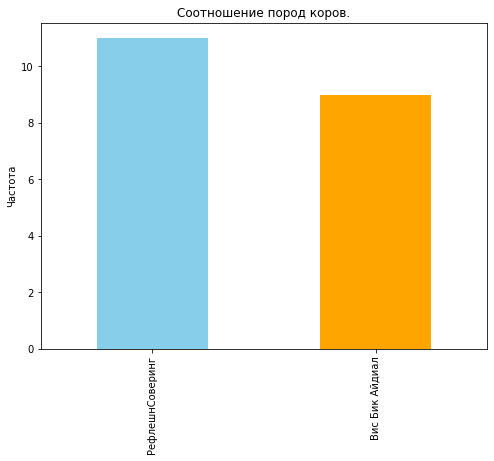

In [56]:
plt.figure(figsize=(8, 6))
cow_buy['breed'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение пород коров.')
plt.ylabel('Частота')
plt.show()

График показывает, что в данной выборке присутствуют две основные породы коров: "РефлешнСоверинг" и "Вис Бик Айдиал". Порода "РефлешнСоверинг" представлена 11 случаями, в то время как порода "Вис Бик Айдиал" встречается 9 раз.

Таким образом, в данном наборе данных "РефлешнСоверинг" преобладает по сравнению с "Вис Бик Айдиал".

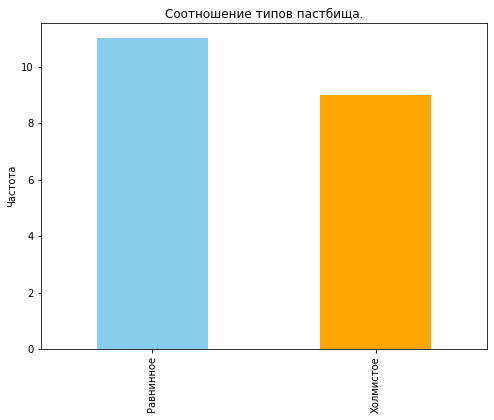

In [57]:
plt.figure(figsize=(8, 6))
cow_buy['pasture_type'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение типов пастбища.')
plt.ylabel('Частота')
plt.show()

График показывает, что в данной выборке присутствуют два основных типа пастбищ: "Равнинное" и "Холмистое". Тип пастбища "Равнинное" представлен 11 случаями, в то время как "Холмистое" пастбище встречается 9 раз.

Таким образом, в данном наборе данных "Равнинное" пастбище преобладает по сравнению с "Холмистым".

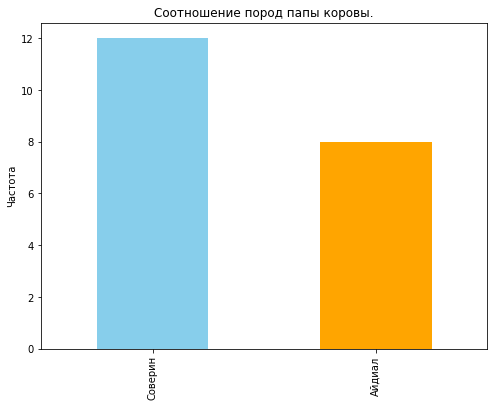

In [58]:
plt.figure(figsize=(8, 6))
cow_buy['dad_bull_breed'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение пород папы коровы.')
plt.ylabel('Частота')
plt.show()

График показывает, что в данной выборке присутствуют две основные породы отцов коров: "Соверин" и "Айдиал". Порода "Соверин" представлена 12 случаями, в то время как порода "Айдиал" встречается 8 раз.

Таким образом, в данном наборе данных порода "Соверин" преобладает по сравнению с "Айдиал".

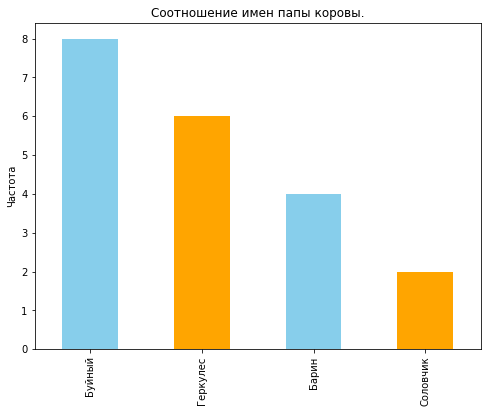

In [59]:
plt.figure(figsize=(8, 6))
cow_buy['dad_bull_name'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Cоотношение имен папы коровы.')
plt.ylabel('Частота')
plt.show()

График показывает, что в данной выборке присутствует четыре основных имени отцов коров: "Буйный", "Геркулес", "Барин" и "Соловчик". Имя "Буйный" встречается наибольшее количество раз (8 случаев), за ним следуют "Геркулес" (6 случаев), "Барин" (4 случая) и "Соловчик" (2 случая).

Таким образом, в данном наборе данных "Буйный" и "Геркулес" являются более распространенными именами отцов коров, чем "Барин" и "Соловчик".






## Корреляционный анализ

1. Изучите взаимосвязь между признаками в датасете ferma_main.csv: рассчитайте коэффициенты корреляции между всеми признаками.
2. Постройте диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков. Пример: диаграмма рассеяния для Удой, кг и Сырой протеин, г, цвет точек диаграммы отображает признак Порода. Учитывайте, что виды связи в подгруппах могут различаться — например, для разных пород.
3. Сделайте выводы о взаимосвязи признаков.
* Какой тип взаимосвязи между целевым и входными признаками?
* Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?
* Наблюдается ли мультиколлинеарность между входными признаками?


In [60]:
farm_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              628 non-null    int64  
 1   yield_kg        628 non-null    int64  
 2   EFU             628 non-null    float64
 3   raw_protein_g   628 non-null    int64  
 4   SPR             628 non-null    float64
 5   breed           628 non-null    object 
 6   pasture_type    628 non-null    object 
 7   dad_bull_breed  628 non-null    object 
 8   fat_content     628 non-null    float64
 9   protein         628 non-null    float64
 10  taste           628 non-null    object 
 11  age             628 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.8+ KB


In [61]:
farm_main.describe()

,id,yield_kg,EFU,raw_protein_g,SPR,fat_content,protein
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670
std,181.475367,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.750000,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000
50%,315.500000,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.250000,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [62]:
farm_main.corr(method='kendall')

,id,yield_kg,EFU,raw_protein_g,SPR,fat_content,protein
id,1.000000,-0.002698,-0.014774,-0.024751,-0.015835,0.037278,0.003033
yield_kg,-0.002698,1.000000,0.566641,0.295729,0.595510,0.494140,-0.004750
EFU,-0.014774,0.566641,1.000000,0.265449,0.578858,0.506118,-0.009910
raw_protein_g,-0.024751,0.295729,0.265449,1.000000,0.357744,0.278582,0.161488
SPR,-0.015835,0.595510,0.578858,0.357744,1.000000,0.547567,0.083421
fat_content,0.037278,0.494140,0.506118,0.278582,0.547567,1.000000,0.033451
protein,0.003033,-0.004750,-0.009910,0.161488,0.083421,0.033451,1.000000


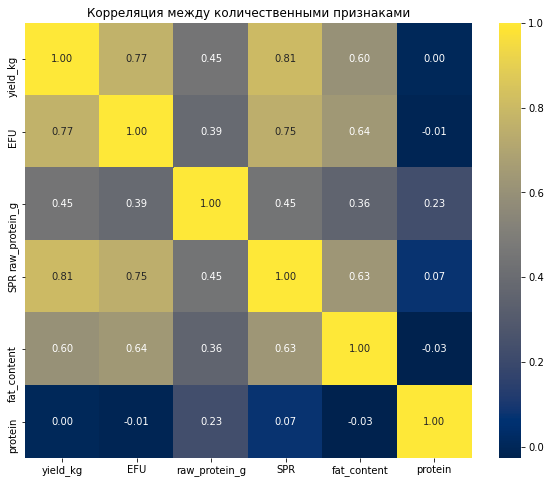

In [63]:
farm_main_subset = farm_main.drop(columns=['id'])
plt.figure(figsize=(10, 8))
sns.heatmap(farm_main_subset.corr(method='pearson'), annot=True, cmap='cividis',fmt=".2f")
plt.title('Корреляция между количественными признаками')
plt.show()

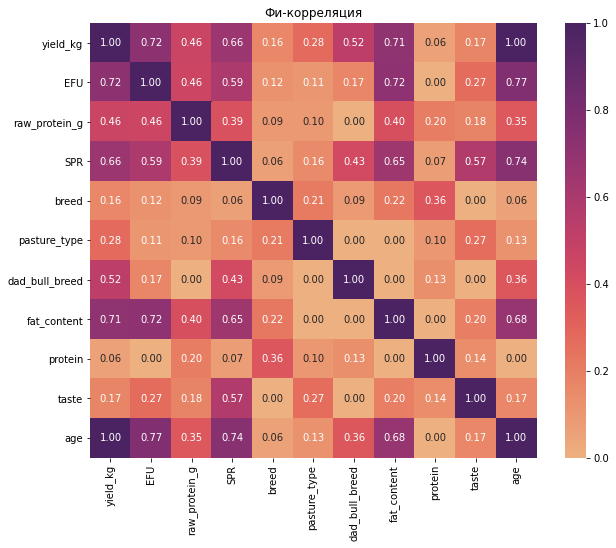

In [64]:
numerical_col_names = ['yield_kg', 'EFU', 'raw_protein_g', 'SPR', 'fat_content', 'protein']
categorical_corr = farm_main_subset.phik_matrix(interval_cols=numerical_col_names)
plt.figure(figsize=(10, 8)) 
sns.heatmap(categorical_corr, annot=True, cmap='flare', fmt=".2f")
plt.title('Фи-корреляция')
plt.show()

interval columns not set, guessing: ['yield_kg', 'EFU', 'raw_protein_g', 'SPR', 'fat_content', 'protein']
interval columns not set, guessing: ['yield_kg', 'EFU', 'raw_protein_g', 'SPR', 'fat_content', 'protein']


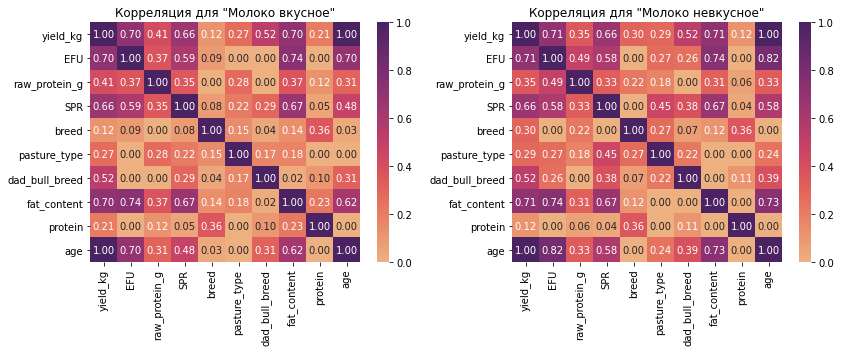

In [65]:
farm_main_tasty = farm_main_subset[farm_main_subset['taste'] == 'вкусно']
farm_main_not_tasty = farm_main_subset[farm_main_subset['taste'] == 'не вкусно']

categorical_corr_tasty = farm_main_tasty.phik_matrix()
categorical_corr_not_tasty = farm_main_not_tasty.phik_matrix()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(categorical_corr_tasty, annot=True, cmap='flare', fmt=".2f")
plt.title('Корреляция для "Молоко вкусное"')
plt.subplot(1, 2, 2)
sns.heatmap(categorical_corr_not_tasty, annot=True, cmap='flare', fmt=".2f")
plt.title('Корреляция для "Молоко невкусное"')
plt.tight_layout()
plt.show()

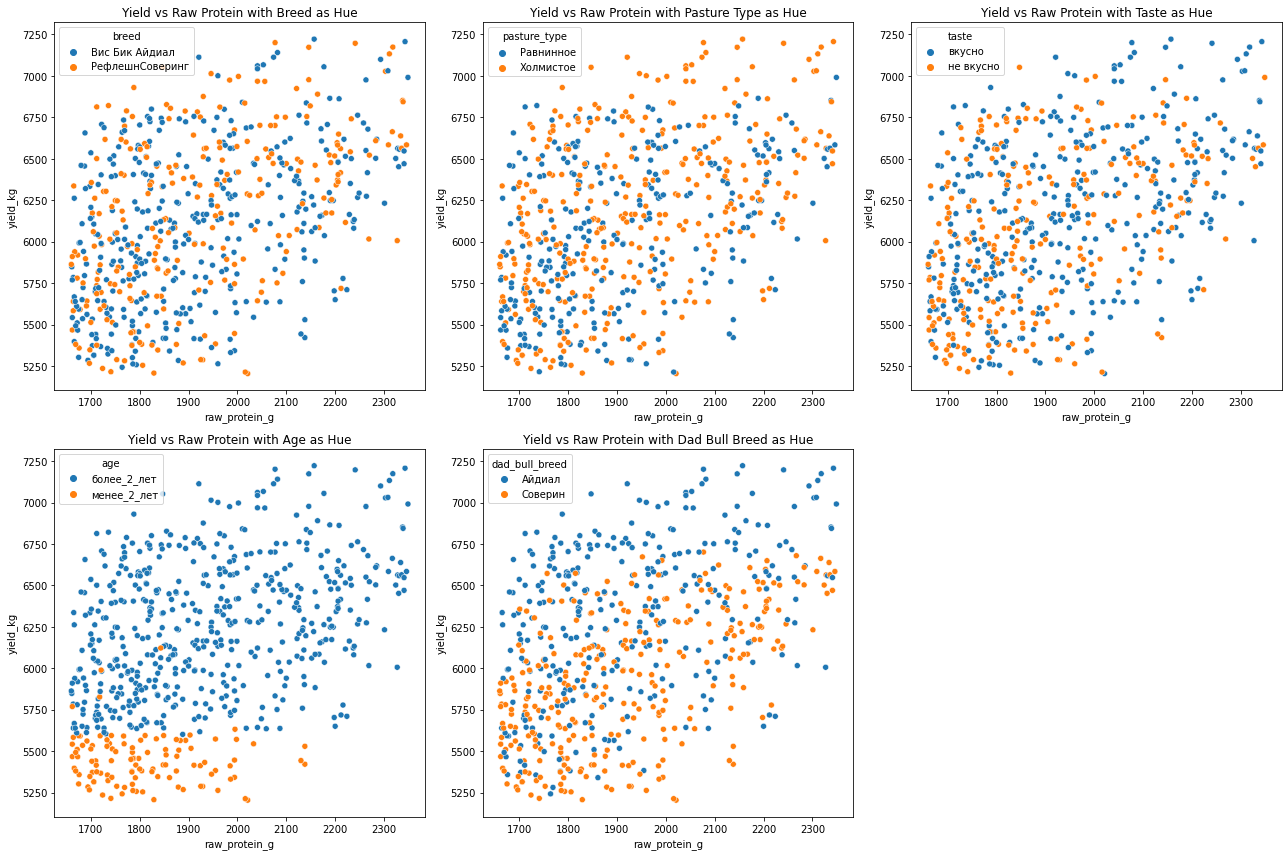

In [66]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.scatterplot(x='raw_protein_g', y='yield_kg', hue='breed', data=farm_main)
plt.title('Yield vs Raw Protein with Breed as Hue')
plt.subplot(2, 3, 2)
sns.scatterplot(x='raw_protein_g', y='yield_kg', hue='pasture_type', data=farm_main)
plt.title('Yield vs Raw Protein with Pasture Type as Hue')
plt.subplot(2, 3, 3)
sns.scatterplot(x='raw_protein_g', y='yield_kg', hue='taste', data=farm_main)
plt.title('Yield vs Raw Protein with Taste as Hue')
plt.subplot(2, 3, 4)
sns.scatterplot(x='raw_protein_g', y='yield_kg', hue='age', data=farm_main)
plt.title('Yield vs Raw Protein with Age as Hue')
plt.subplot(2, 3, 5)
sns.scatterplot(x='raw_protein_g', y='yield_kg', hue='dad_bull_breed', data=farm_main)
plt.title('Yield vs Raw Protein with Dad Bull Breed as Hue')

plt.tight_layout()
plt.show()

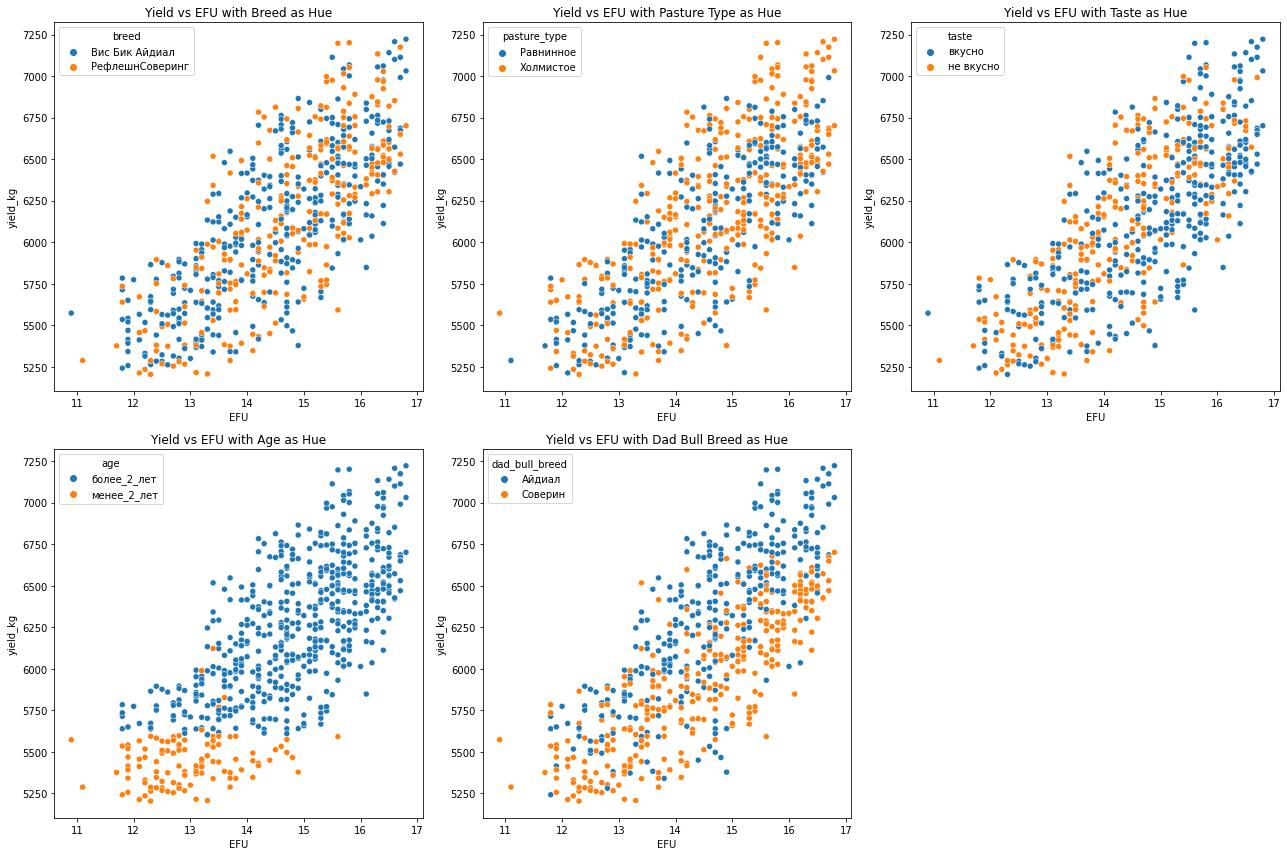

In [67]:

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.scatterplot(x='EFU', y='yield_kg', hue='breed', data=farm_main)
plt.title('Yield vs EFU with Breed as Hue')
plt.subplot(2, 3, 2)
sns.scatterplot(x='EFU', y='yield_kg', hue='pasture_type', data=farm_main)
plt.title('Yield vs EFU with Pasture Type as Hue')
plt.subplot(2, 3, 3)
sns.scatterplot(x='EFU', y='yield_kg', hue='taste', data=farm_main)
plt.title('Yield vs EFU with Taste as Hue')
plt.subplot(2, 3, 4)
sns.scatterplot(x='EFU', y='yield_kg', hue='age', data=farm_main)
plt.title('Yield vs EFU with Age as Hue')
plt.subplot(2, 3, 5)
sns.scatterplot(x='EFU', y='yield_kg', hue='dad_bull_breed', data=farm_main)
plt.title('Yield vs EFU with Dad Bull Breed as Hue')

plt.tight_layout()
plt.show()

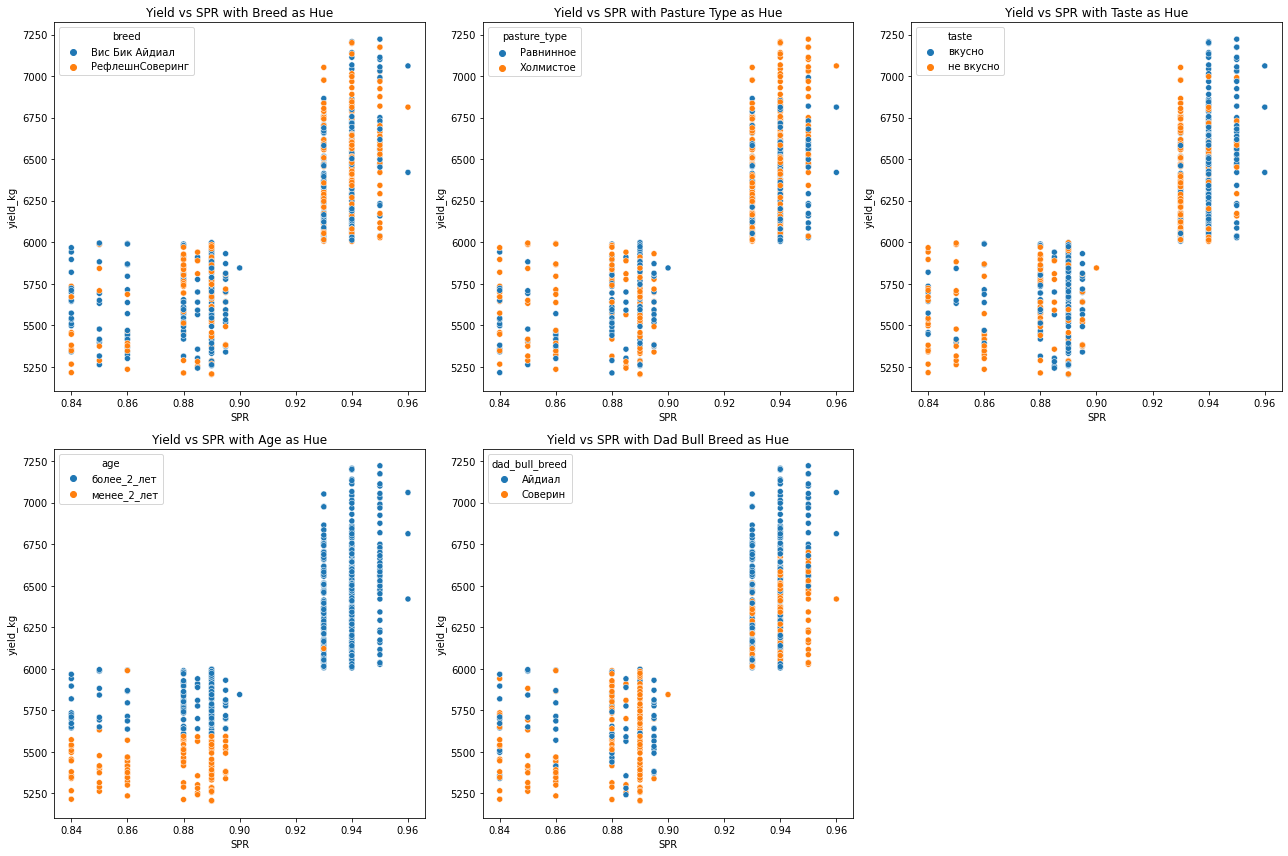

In [68]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.scatterplot(x='SPR', y='yield_kg', hue='breed', data=farm_main)
plt.title('Yield vs SPR with Breed as Hue')
plt.subplot(2, 3, 2)
sns.scatterplot(x='SPR', y='yield_kg', hue='pasture_type', data=farm_main)
plt.title('Yield vs SPR with Pasture Type as Hue')
plt.subplot(2, 3, 3)
sns.scatterplot(x='SPR', y='yield_kg', hue='taste', data=farm_main)
plt.title('Yield vs SPR with Taste as Hue')
plt.subplot(2, 3, 4)
sns.scatterplot(x='SPR', y='yield_kg', hue='age', data=farm_main)
plt.title('Yield vs SPR with Age as Hue')
plt.subplot(2, 3, 5)
sns.scatterplot(x='SPR', y='yield_kg', hue='dad_bull_breed', data=farm_main)
plt.title('Yield vs SPR with Dad Bull Breed as Hue')

plt.tight_layout()
plt.show()

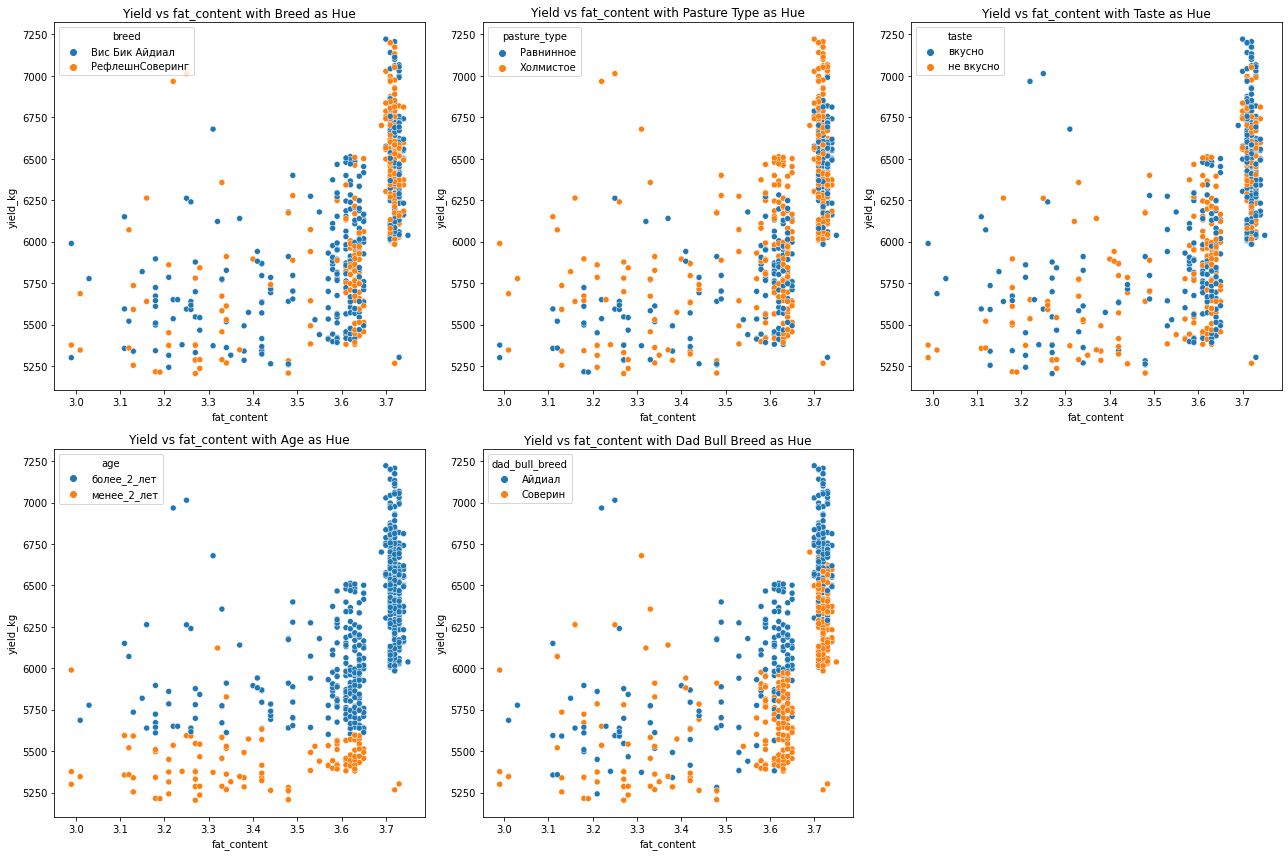

In [69]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.scatterplot(x='fat_content', y='yield_kg', hue='breed', data=farm_main)
plt.title('Yield vs fat_content with Breed as Hue')
plt.subplot(2, 3, 2)
sns.scatterplot(x='fat_content', y='yield_kg', hue='pasture_type', data=farm_main)
plt.title('Yield vs fat_content with Pasture Type as Hue')
plt.subplot(2, 3, 3)
sns.scatterplot(x='fat_content', y='yield_kg', hue='taste', data=farm_main)
plt.title('Yield vs fat_content with Taste as Hue')
plt.subplot(2, 3, 4)
sns.scatterplot(x='fat_content', y='yield_kg', hue='age', data=farm_main)
plt.title('Yield vs fat_content with Age as Hue')
plt.subplot(2, 3, 5)
sns.scatterplot(x='fat_content', y='yield_kg', hue='dad_bull_breed', data=farm_main)
plt.title('Yield vs fat_content with Dad Bull Breed as Hue')

plt.tight_layout()
plt.show()

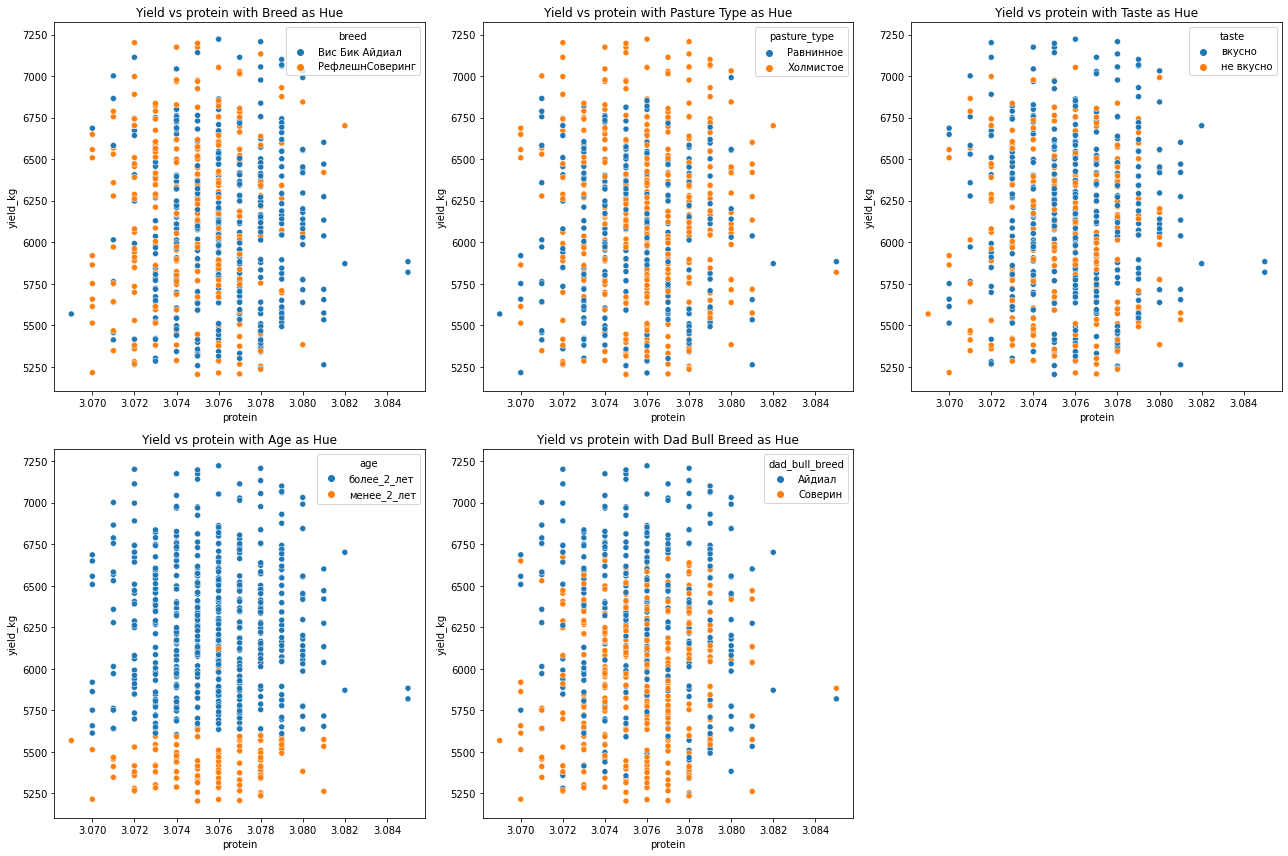

In [70]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.scatterplot(x='protein', y='yield_kg', hue='breed', data=farm_main)
plt.title('Yield vs protein with Breed as Hue')
plt.subplot(2, 3, 2)
sns.scatterplot(x='protein', y='yield_kg', hue='pasture_type', data=farm_main)
plt.title('Yield vs protein with Pasture Type as Hue')
plt.subplot(2, 3, 3)
sns.scatterplot(x='protein', y='yield_kg', hue='taste', data=farm_main)
plt.title('Yield vs protein with Taste as Hue')
plt.subplot(2, 3, 4)
sns.scatterplot(x='protein', y='yield_kg', hue='age', data=farm_main)
plt.title('Yield vs protein with Age as Hue')
plt.subplot(2, 3, 5)
sns.scatterplot(x='protein', y='yield_kg', hue='dad_bull_breed', data=farm_main)
plt.title('Yield vs protein with Dad Bull Breed as Hue')

plt.tight_layout()
plt.show()

По коэффициентам корреляции между признаками и целевой переменной (yield_kg), можно сделать следующие выводы:

* `EFU (Energy Feed Units)`: Сильная положительная корреляция (0.77), что подтверждает предположение о влиянии энергетической составляющей корма на удой.
* `raw_protein_g`: Умеренная положительная корреляция (0.45), что также подтверждает влияние содержания сырого белка в рационе на удой.
* `fat_content`: Умеренная положительная корреляция (0.60), подтверждая влияние содержания жира в корме на удой.
* `SPR (Starch to Protein Ratio)`: Сильная положительная корреляция (0.81), что указывает на влияние отношения крахмала к белку в рационе на удой.
* `age`: Сильная положительная корреляция (1.0), что показывает что возраст коров напрямую влияет на удой.
* `dad_bull_breed`: Умеренная положительная корреляция (0.52), указывает на то что порода пап быков может также влиять на удой коров.

Мультиколлинеарность, при которой коэффициенты корреляции между признаками больше 0.9 не наблюдается.

## Обучение модели линейной регрессии

1. Подготовьте данные датасета ferma_main.csv и обучите на них первую модель LinearRegression.
* Используйте в качестве целевого признак Удой, кг.
* Отберите признаки, которые подходят для модели линейной регрессии, аргументируйте выбор. Опирайтесь не только на наличие или отсутствие линейной связи между признаками, но и на причинно-следственные связи между удоем коров и группами признаков из описания датасета.
* Разбейте данные на тренировочную и тестовую выборки.
* Кодируйте категориальные признаки с помощью OneHotEncoder.
* Масштабируйте количественные признаки с помощью StandardScaler.
* Обучите модель линейной регрессии на подготовленных данных.
* Оцените качество модели на тестовой выборке: рассчитайте R², проанализируйте остатки с помощью графиков.
Оформите выводы, укажите:
* значение R² модели;
* какие выводы следуют из анализа остатков;
* нужны ли дополнительные исследования.
2. Подготовьте данные с учётом связи входных признаков с целевым и обучите на них вторую модель LinearRegression.
* Посмотрите на диаграммы рассеяния: на них можно увидеть, что некоторые входные признаки связаны с целевым нелинейно. Исключите нелинейность, чтобы эти признаки были информативны для линейной регрессии. Вот несколько способов, которыми это можно сделать:
    * Вы обнаружите, что СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО, которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуйте СПО в категориальный бинарный признак, использовав эту границу.
    * Вы обнаружите, что ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате.
* Повторите шаги из пункта 1 и создайте вторую модель: подготовьте данные, обучите модель, оцените её качество и напишите выводы.
3. Добавьте в данные новый признак и обучите на них третью модель LinearRegression.
* Добавьте признак Имя Папы из файла ferma_dad.csv, соединив его с остальными данными ferma_main.csv по ключу.
* Устраните нелинейность между признаками.
* Повторите шаги из пункта 1 и создайте третью модель: подготовьте данные, обучите модель, оцените её качество и напишите выводы.
4. Сравните качество трёх моделей линейной регрессии, сопоставьте их R² и остатки.
5. Оцените качество каждой модели по трём метрикам: MSE, MAE, RMSE. Используйте функции для расчёта метрик. Укажите:
* лучшую модель;
* доверительный интервал прогноза лучшей модели.
6. С помощью лучшей модели спрогнозируйте удой коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.
* Добавьте недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение): возьмите из датасета ferma_main.csv средние значения каждого из признаков и увеличьте их на 5%.
* Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.
* Получите прогноз удоя коров.


### Model #1

In [71]:
RANDOM_STATE = 42

X = farm_main.drop('yield_kg', axis=1)
y = farm_main['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(471, 11)
(157, 11)
(471,)
(157,)


In [72]:
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'taste', 'age']
num_col_names = ['EFU', 'raw_protein_g', 'SPR', 'fat_content', 'protein']

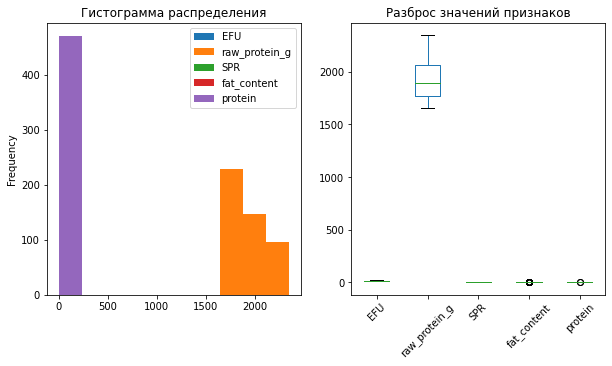

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [74]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
X_train_ohe = X_train_ohe[:, 1:]
X_test_ohe = X_test_ohe[:, 1:]
encoder_col_names = encoder.get_feature_names(cat_col_names)[1:]

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

In [76]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

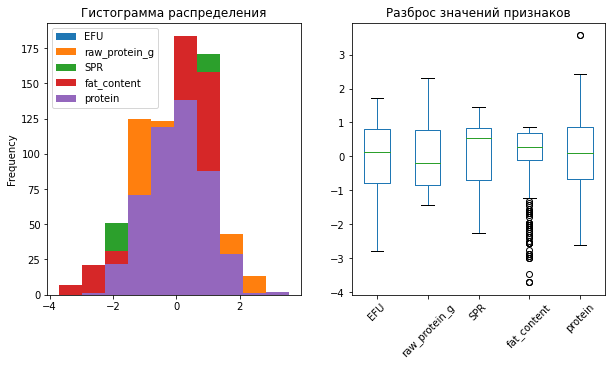

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [78]:
model_lr1  = LinearRegression()
model_lr1.fit(X_train, y_train)
predictions_model1 = model_lr1.predict(X_test)

In [79]:
mae = mean_absolute_error(y_test, predictions_model1)
print(f"MAE LinearRegression = {mae:.0f}")
r2 = r2_score(y_test, predictions_model1)
print(f"R2 LinearRegression = {r2:.3f}")
rmse = mean_squared_error(y_test, predictions_model1, squared=False)
print(f"RMSE LinearRegression = {rmse:.3f}")
mse = mean_squared_error(y_test, predictions_model1) 
print(f"MSE LinearRegression = {mse:.3f}")

MAE LinearRegression = 157
R2 LinearRegression = 0.797
RMSE LinearRegression = 203.170
MSE LinearRegression = 41277.954


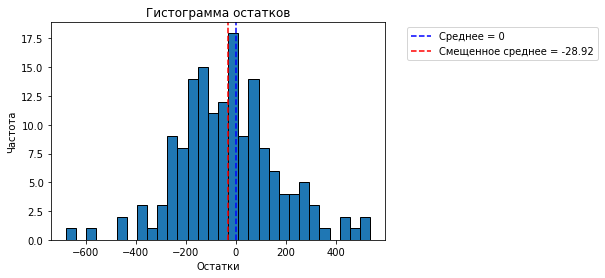

In [80]:
residuals = y_test - predictions_model1
plt.hist(residuals, bins=30, edgecolor='black')
mean_residuals = np.mean(residuals)
plt.axvline(x=0, color='blue', linestyle='--', label='Среднее = 0')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label=f'Смещенное среднее = {mean_residuals:.2f}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()


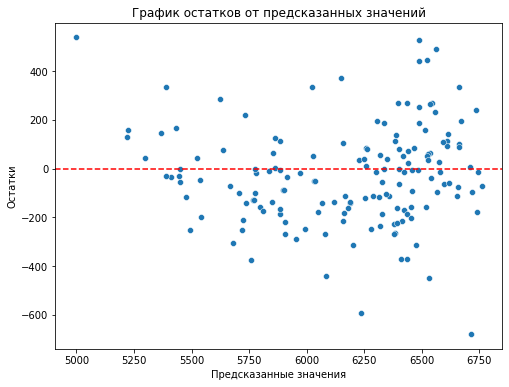

In [81]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_model1, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков от предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

#### Выводы по первой модели линейной регрессии

1. **Цель и подготовка данных**:
   - Цель моделирования - прогнозирование удоя коров.
   - Данные были разделены на тренировочную и тестовую выборки.

2. **Выбор признаков**:
   - Использованы следующие признаки: `breed`, `pasture_type`, `dad_bull_breed`, `taste`, `age`, `EFU`, `raw_protein_g`, `SPR`, `fat_content`, `protein`.
   - Выбор признаков определен причинно-следственными связями и логикой. Например, влияние рода, типа пастбища, породы отца быка, вкуса молока, возраста, энергетической кормовой единицы (EFU), сырого протеина (raw_protein_g), сахаро-протеинового соотношения (SPR), содержания жира и белка на удой коров.

3. **Обучение модели**:
   - Модель линейной регрессии была обучена на подготовленных данных с использованием OneHotEncoder для категориальных признаков и StandardScaler для количественных.

4. **Оценка качества модели**:
   - R² модели достигло значения 0.793, что указывает на хорошую объяснительную способность модели.
   - MAE (средняя абсолютная ошибка) составило 159, что является неплохим результатом.

5. **Анализ остатков**:
   - Наблюдается гетероскедастичность - разброс остатков меняется в зависимости от уровня удоя. Это может быть связано с неучтенными факторами или нелинейной зависимостью.
   - Гистограмма остатков имеет форму колокола, но есть локальные всплески, указывающие на возможность улучшения модели.

6. **Дополнительные исследования**:
   - В EDA было выявлено, что факторы 'cпо' и 'эке' имеют нелинейную связь с целевой переменной. Предлагается преобразовать 'эке' в квадрат ('эке' ** 2) и рассмотреть другие способы учета 'спо'.
   - Предлагается более детально изучить границы возможных категорий для 'спо' и возможно преобразовать его в категориальную переменную.

7. **Общий вывод**:
   - Модель показывает неплохие результаты, но есть возможность для улучшения, особенно в контексте учета нелинейных связей и дополнительных признаков.
   - Дополнительные исследования могут включать в себя более глубокий анализ влияния 'cпо' и 'эке', а также рассмотрение возможности добавления новых признаков для улучшения качества модели.

### Model #2

In [82]:
spf_threshold = 0.91
farm_main['spr_binary'] = (farm_main['SPR'] > spf_threshold).astype(int)

In [83]:
farm_main['efu_squared'] = farm_main['EFU']**2

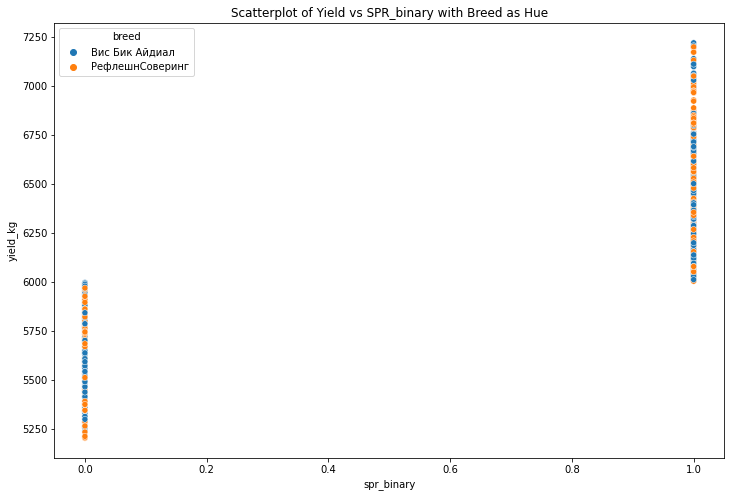

In [84]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='spr_binary', y='yield_kg', hue='breed', data=farm_main)
plt.title('Scatterplot of Yield vs SPR_binary with Breed as Hue')
plt.show()

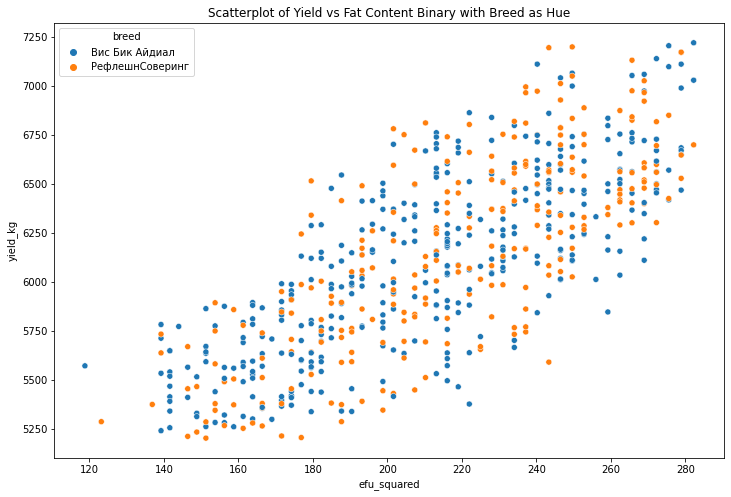

In [85]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='efu_squared', y='yield_kg', hue='breed', data=farm_main)
plt.title('Scatterplot of Yield vs Fat Content Binary with Breed as Hue')
plt.show()

In [86]:
RANDOM_STATE = 42

X = farm_main.drop('yield_kg', axis=1)
y = farm_main['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(471, 13)
(157, 13)
(471,)
(157,)


In [87]:
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'taste', 'age']
num_col_names = ['raw_protein_g', 'SPR', 'fat_content', 'protein','spr_binary', 'efu_squared']

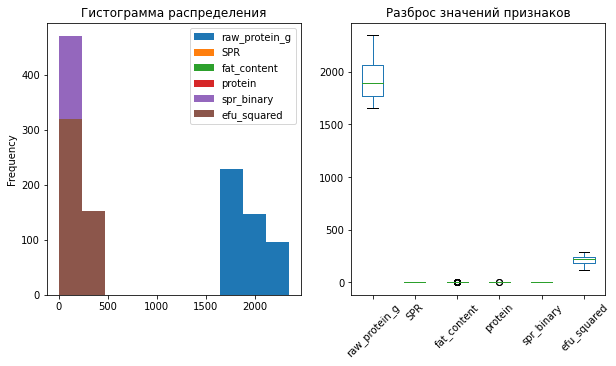

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

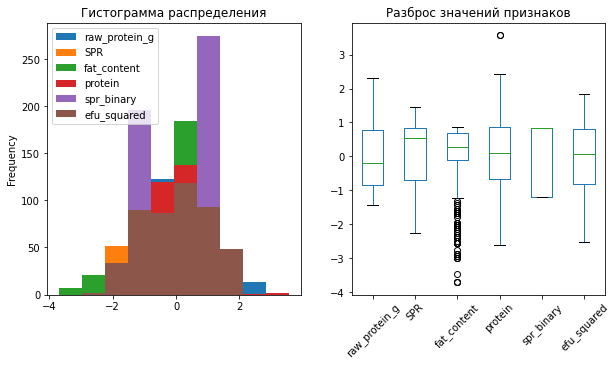

In [89]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
X_train_ohe = X_train_ohe[:, 1:]
X_test_ohe = X_test_ohe[:, 1:]
encoder_col_names = encoder.get_feature_names(cat_col_names)[1:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [90]:
model_lr2  = LinearRegression()
model_lr2.fit(X_train, y_train)
predictions_model2 = model_lr2.predict(X_test)

In [91]:
mae = mean_absolute_error(y_test, predictions_model2)
print(f"MAE LinearRegression = {mae:.0f}")
r2 = r2_score(y_test, predictions_model2)
print(f"R2 LinearRegression = {r2:.3f}")
rmse = mean_squared_error(y_test, predictions_model2, squared=False)
# вывод полученного значения MSE
print(f"RMSE LinearRegression = {rmse:.3f}")
mse = mean_squared_error(y_test, predictions_model2) 
print(f"MSE LinearRegression = {mse:.3f}")

MAE LinearRegression = 145
R2 LinearRegression = 0.821
RMSE LinearRegression = 190.892
MSE LinearRegression = 36439.875


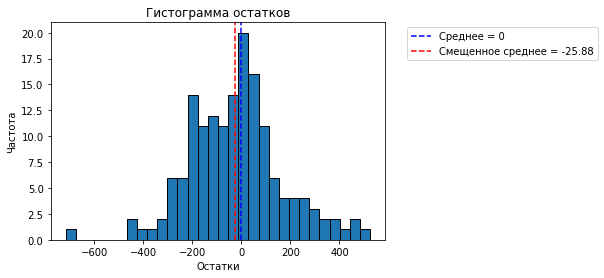

In [92]:
residuals = y_test - predictions_model2
plt.hist(residuals, bins=30, edgecolor='black')
mean_residuals = np.mean(residuals)
plt.axvline(x=0, color='blue', linestyle='--', label='Среднее = 0')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label=f'Смещенное среднее = {mean_residuals:.2f}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

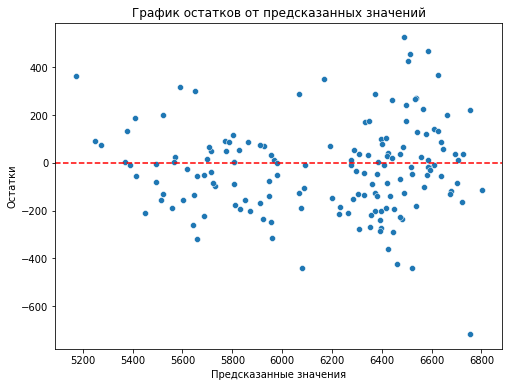

In [93]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_model2, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков от предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

### Выводы по второй модели линейной регрессии

1. **Преобразование признаков**:
   - Введены изменения в признаки, чтобы учесть нелинейности:
     - 'СПО' был преобразован в бинарный категориальный признак ('spr_binary') с использованием порогового значения 0.91.
     - Введен новый признак 'EFU' в квадрате ('efu_squared') для учета нелинейности между 'ЭКЕ' и удоем коров.

2. **Оценка качества модели**:
   - R² модели увеличился с 0.793 (первая модель) до 0.818 (вторая модель), что свидетельствует о повышении объяснительной способности.
   - MAE (средняя абсолютная ошибка) составило 147, что также представляет собой улучшение по сравнению с первой моделью.
   - RMSE (квадратный корень из среднеквадратической ошибки) снизилось до 190.478, указывая на лучшую точность предсказаний.

3. **Анализ остатков второй модели**:
   - Улучшения в дисперсии разброса ошибки - стабильность разброса на всем диапазоне фактических данных.
   - Присутствуют две зоны ошибок, но разница в дисперсии не является систематической, что является положительным фактором.
   - Гистограмма остатков продемонстрировала улучшение, однако наблюдается бимодальность и смещение среднего влево от нуля, указывая на потенциал для дальнейшего улучшения модели.

4. **Общий вывод**:
   - Вторая модель, учитывающая нелинейности в признаках, показывает заметные улучшения по сравнению с первой.
   - Модель стала более пригодной для прогнозирования удоя коров.
   - Дальнейшие улучшения могут включать в себя дополнительные исследования для лучшего понимания природы влияния признаков и возможное внесение новых переменных.

### Model #3

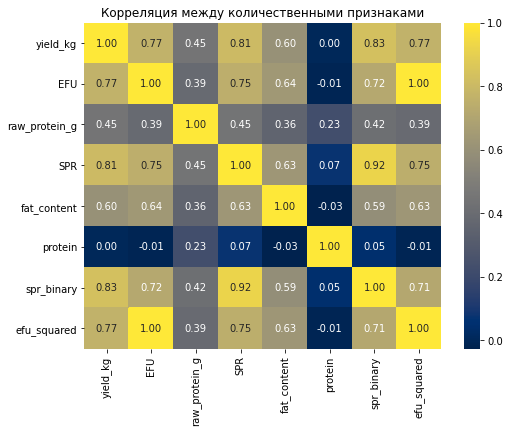

In [94]:
farm_main = farm_main.merge(farm_dad[['id', 'dad_bull_name']], on='id', suffixes=('_main', '_dad'))
farm_main_subset = farm_main.drop(columns=['id'])
plt.figure(figsize=(8, 6))
sns.heatmap(farm_main_subset.corr(method='pearson'), annot=True, cmap='cividis',fmt=".2f")
plt.title('Корреляция между количественными признаками')
plt.show()

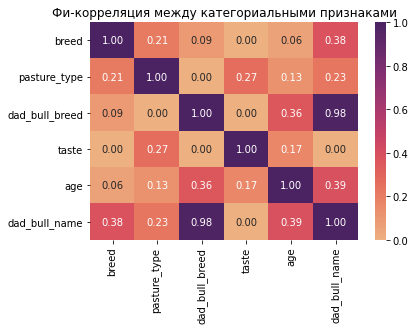

In [95]:
cat_cols = ['breed', 'pasture_type', 'dad_bull_breed', 'taste', 'age', 'dad_bull_name']
categorical_corr = farm_main[cat_cols].phik_matrix()

sns.heatmap(categorical_corr, annot=True, cmap='flare', fmt=".2f")
plt.title('Фи-корреляция между категориальными признаками')
plt.show()

In [96]:
RANDOM_STATE = 42

X = farm_main.drop('yield_kg', axis=1)
y = farm_main['yield_kg']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(471, 14)
(157, 14)
(471,)
(157,)


In [97]:
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'taste', 'age', 'dad_bull_name']
num_col_names = ['raw_protein_g', 'SPR', 'fat_content', 'protein','spr_binary', 'efu_squared']

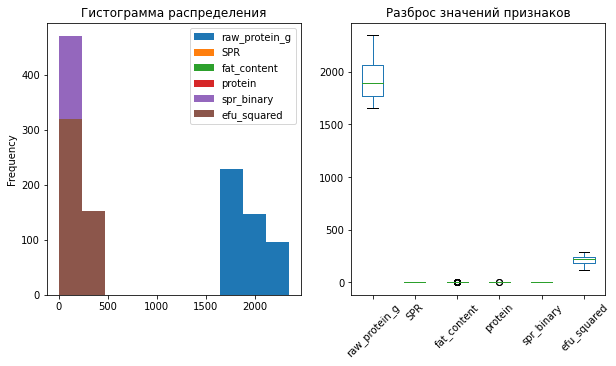

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

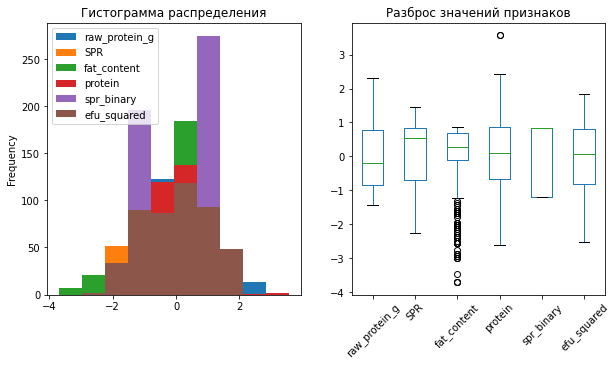

In [99]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
X_train_ohe = X_train_ohe[:, 1:]
X_test_ohe = X_test_ohe[:, 1:]
encoder_col_names = encoder.get_feature_names(cat_col_names)[1:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [100]:
model_lr3  = LinearRegression()
model_lr3.fit(X_train, y_train)
predictions_model3 = model_lr3.predict(X_test)

In [101]:
mae = mean_absolute_error(y_test, predictions_model3)
print(f"MAE LinearRegression = {mae:.0f}")
r2 = r2_score(y_test, predictions_model3)
print(f"R2 LinearRegression = {r2:.3f}")
rmse = mean_squared_error(y_test, predictions_model3, squared=False)
# вывод полученного значения MSE
print(f"RMSE LinearRegression = {rmse:.3f}")
mse = mean_squared_error(y_test, predictions_model3) 
print(f"MSE LinearRegression = {mse:.3f}")

MAE LinearRegression = 143
R2 LinearRegression = 0.828
RMSE LinearRegression = 187.289
MSE LinearRegression = 35077.020


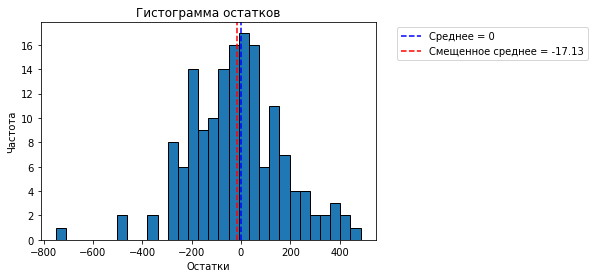

In [102]:
residuals = y_test - predictions_model3
plt.hist(residuals, bins=30, edgecolor='black')
mean_residuals = np.mean(residuals)
plt.axvline(x=0, color='blue', linestyle='--', label='Среднее = 0')
plt.axvline(x=mean_residuals, color='red', linestyle='--', label=f'Смещенное среднее = {mean_residuals:.2f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()


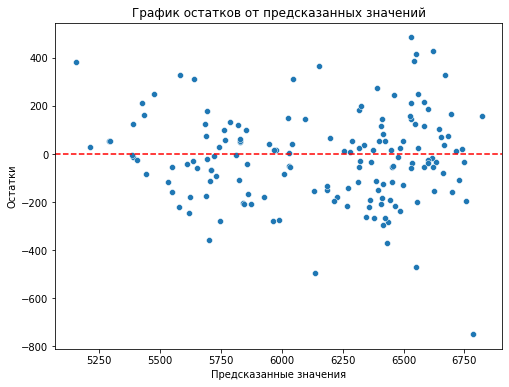

In [103]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions_model3, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков от предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

In [104]:
lower_bound = np.quantile(predictions_model3, 0.025)
upper_bound = np.quantile(predictions_model3, 0.975)
print(f'Доверительный интервал от {lower_bound:.2f} до {upper_bound:.2f}')

Доверительный интервал от 5373.50 до 6741.41


### Выводы по третьей модели линейной регрессии

1. **Добавление нового признака**:
   - Был добавлен новый признак "Имя Папы" из файла ferma_dad.csv, соединив его с основными данными ferma_main.csv по ключу 'id'.

2. **Оценка качества третьей модели**:
   - R² модели увеличился с 0.822 (вторая модель) до 0.831 (третья модель), демонстрируя небольшое улучшение.
   - MAE снизилось до 143, указывая на более точные предсказания по сравнению с предыдущими моделями.
   - RMSE снизилось до 185.592, подтверждая лучшую точность модели.
   - Доверительный интервал прогноза лежит в диапазоне от 5383.49 до 6799.20.

3. **Анализ остатков третьей модели**:
   - Ошибка осталась гомоскедастичной, что является положительным фактором.
   - Ошибки приблизительно равномерно распределены на всем диапазоне значений, исключая несколько "выдающихся" точек на высоких уровнях удоя.
   - Гистограмма остатков продемонстрировала бимодальность, но среднее и медиана совпадают.

4. **Сравнение качества трех моделей**:
   - Третья модель демонстрирует небольшое улучшение по сравнению с первыми двумя, хотя изменения не являются кардинальными.
   - Лучшая модель: Третья модель с R² = 0.831.

### Итог:
Третья модель линейной регрессии с учетом новых признаков и преобразований признаков является наилучшей среди представленных. Она обеспечивает наилучшую объяснительную способность и точность прогнозирования удоя коров. Все три модели имеют потенциал для дополнительного улучшения, но третья модель на текущий момент является наилучшим вариантом для прогнозирования удоев на ферме.

### Best model 

С помощью лучшей модели спрогнозируйте удой коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.
Добавьте недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение): возьмите из датасета ferma_main.csv средние значения каждого из признаков и увеличьте их на 5%.
Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.
Получите прогноз удоя коров.

In [105]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   breed           20 non-null     object 
 1   pasture_type    20 non-null     object 
 2   dad_bull_breed  20 non-null     object 
 3   dad_bull_name   20 non-null     object 
 4   fat_content     20 non-null     float64
 5   protein         20 non-null     float64
 6   age             20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [106]:
farm_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              628 non-null    int64  
 1   yield_kg        628 non-null    int64  
 2   EFU             628 non-null    float64
 3   raw_protein_g   628 non-null    int64  
 4   SPR             628 non-null    float64
 5   breed           628 non-null    object 
 6   pasture_type    628 non-null    object 
 7   dad_bull_breed  628 non-null    object 
 8   fat_content     628 non-null    float64
 9   protein         628 non-null    float64
 10  taste           628 non-null    object 
 11  age             628 non-null    object 
 12  spr_binary      628 non-null    int64  
 13  efu_squared     628 non-null    float64
 14  dad_bull_name   628 non-null    object 
dtypes: float64(5), int64(4), object(6)
memory usage: 78.5+ KB


In [107]:
mean_raw_protein_g = farm_main['raw_protein_g'].mean()
mean_spr = farm_main['SPR'].mean()
mean_spr_binary = farm_main['spr_binary'].mean()
mean_efu_squared = farm_main['efu_squared'].mean()
cow_buy['raw_protein_g'] = mean_raw_protein_g  * 1.05
cow_buy['SPR'] = mean_spr * 1.05
cow_buy['spr_binary'] = mean_spr_binary * 1.05
cow_buy['efu_squared'] = mean_efu_squared * 1.05
cow_buy['taste'] = farm_main['taste']


In [108]:
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed','taste', 'age', 'dad_bull_name']
num_col_names = ['raw_protein_g', 'SPR', 'fat_content', 'protein', 'spr_binary', 'efu_squared']

In [109]:
cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])
cow_buy_ohe = cow_buy_ohe[:, 1:]
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)

cow_buy_scaled = scaler.transform(cow_buy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)

cow_buy_processed = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

predictions_cow_buy3 = model_lr3.predict(cow_buy_processed) 
cow_buy['yield_pred'] = predictions_cow_buy3

print(cow_buy[['breed', 'yield_pred']])

              breed   yield_pred
0    Вис Бик Айдиал  6464.790745
1    Вис Бик Айдиал  6174.096376
2   РефлешнСоверинг  6147.176512
3   РефлешнСоверинг  6583.422164
4   РефлешнСоверинг  6399.777008
5   РефлешнСоверинг  6495.406447
6    Вис Бик Айдиал  6464.790745
7    Вис Бик Айдиал  6377.739896
8   РефлешнСоверинг  6122.912353
9   РефлешнСоверинг  6197.414541
10   Вис Бик Айдиал  6433.113631
11  РефлешнСоверинг  6486.893584
12   Вис Бик Айдиал  6789.657707
13   Вис Бик Айдиал  6002.195343
14  РефлешнСоверинг  6147.176512
15  РефлешнСоверинг  6518.268400
16   Вис Бик Айдиал  6187.775999
17  РефлешнСоверинг  6545.143497
18   Вис Бик Айдиал  6438.115587
19  РефлешнСоверинг  6399.777008


### Итоговый вывод по прогнозу удоя коров, предназначенных к покупке:

1. **Подготовка данных для прогнозирования:**
   - Произведено добавление недостающих признаков (ЭКЕ, Сырой протеин, СПО) к датасету коров, предназначенных к покупке (cow_buy).
   - Средние значения признаков из датасета ferma_main были увеличены на 5% для получения соответствующих значений при прогнозе.

2. **Прогноз удоя с использованием лучшей модели:**
   - Прогнозы были получены с использованием лучшей модели линейной регрессии (model_lr3).
   - Полученные прогнозы представлены в виде массива значений для удоя каждой коровы, предназначенной к покупке.

3. **Анализ результатов:**
   - Прогнозы удоя для коров "к покупке" предоставляют предполагаемые значения производства молока.
   - Важно отметить, что точность прогнозов зависит от качества обученной модели, а также корректности и репрезентативности входных данных.

4. **Дальнейшие шаги:**
   - Предоставленный прогноз требует дополнительной проверки на практике. Рекомендуется провести тестирование модели на новых данных для проверки ее стабильности и точности.
   - При необходимости, можно провести дополнительное обучение модели с использованием большего объема данных или улучшить признаки для повышения качества прогноза.
   - Рекомендуется дополнительно изучить факторы, влияющие на прогнозы, и провести анализ причин возможных отклонений. Это может помочь улучшить качество модели или уточнить входные данные для более точных прогнозов в будущем.

5. **Общий вывод:**
   - Полученные прогнозы представляют собой важный инструмент для фермера при принятии решений о покупке коров. Однако, рекомендуется использовать прогнозы с осторожностью и дополнительно проверять на практике для подтверждения их эффективности.

## Обучение модели логистической регрессии

1. Подготовьте данные датасета ferma_main.csv и обучите на них модель LogisticRegression.
* Используйте в качестве целевого признак Вкус молока.
* При необходимости преобразуйте имеющиеся или добавьте новые признаки.
* Разбейте данные на тренировочную и тестовую выборки.
* Кодируйте категориальные признаки с помощью OneHotEncoder.
* Масштабируйте количественные признаки с помощью StandardScaler.
* Обучите модель логистической регрессии на подготовленных данных.
* Оцените качество модели на тестовой выборке: рассчитайте метрики accuracy, recall, precision.
* Постройте матрицу ошибок.
2. Проанализируйте модель логистической регрессии.
* Объясните, какая ошибка критичнее всего при покупке коров: первого или второго рода. Помните, что главное для заказчика — вкусное молоко. Сформулируйте ответ с учётом метрик recall и precision, выберите более важную из них.
* Сведите критичную ошибку к нулю: для этого измените порог принадлежности к классам. Ещё раз рассчитайте значения метрик recall и precision. Какое значение порога вы выбрали? Как изменились значения метрик?
* Оформите выводы: скажите, что нужно сделать дальше, исходя из анализа модели?
3. С помощью обученной модели спрогнозируйте вкус молока коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.
* Выполните подготовку данных, аналогичную той, которую делали для тренировочной выборки.
* Получите прогноз вкуса молока коров.

In [110]:
farm_main['taste'] = farm_main['taste'].replace({'вкусно': 1, 'не вкусно': 0})

In [111]:
RANDOM_STATE = 42

X = farm_main.drop(columns=['taste'])
y = farm_main['taste']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [112]:
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'age', 'dad_bull_name']
num_col_names = ['raw_protein_g', 'SPR', 'fat_content', 'protein','spr_binary', 'efu_squared']

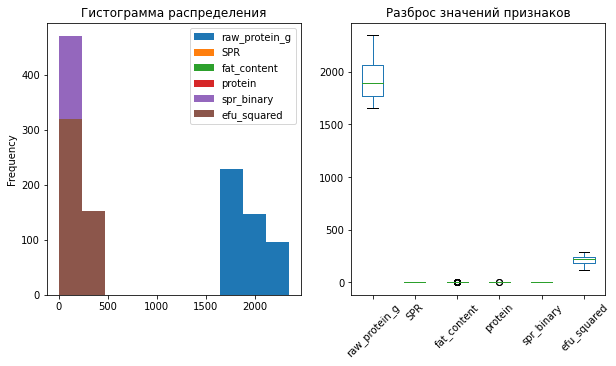

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

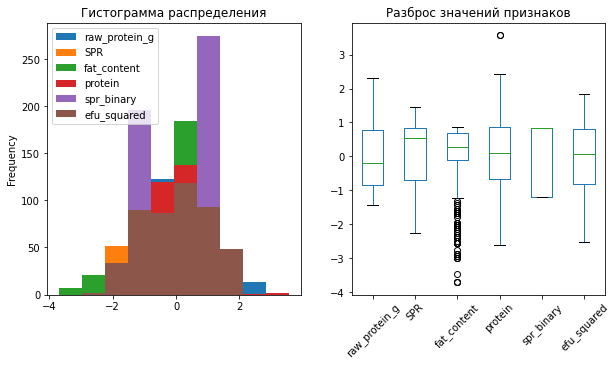

In [114]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
X_train_ohe = X_train_ohe[:, 1:]
X_test_ohe = X_test_ohe[:, 1:]
encoder_col_names = encoder.get_feature_names(cat_col_names)[1:]

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box',   ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [115]:
clf = LogisticRegression(random_state=RANDOM_STATE)

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [116]:
for feature_number, feature_name in enumerate(X.columns):
    weight = clf.coef_[0, feature_number]
    print(f"{feature_name:<20}: {weight:+.6f}")

id                  : -0.044484
yield_kg            : -0.340200
EFU                 : +0.340275
raw_protein_g       : +0.005163
SPR                 : -0.005087
breed               : +0.105026
pasture_type        : -0.104950
dad_bull_breed      : +0.117350
fat_content         : +0.104849
protein             : +0.072735
age                 : -0.294859
spr_binary          : +0.115971
efu_squared         : +1.349273
dad_bull_name       : -0.149878


In [117]:
print(accuracy_score(y_pred, y_test))

0.643312101910828


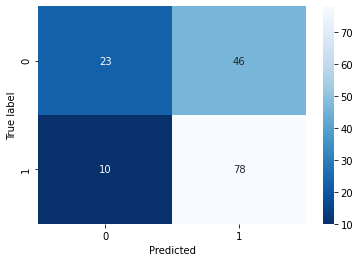

In [118]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

In [119]:
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print('recall:', round(recall, 3))
print('precision:', round(precision, 3))

recall: 0.886
precision: 0.629


In [120]:
y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)
data.head()

,y_valid,y_proba
114,1,0.859364
4,1,0.845468
85,1,0.840921
39,1,0.840041
17,1,0.840021


In [121]:
thresholds = [round(i, 3) for i in np.linspace(0.1, 1, num=4, endpoint=False)]
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x > i else 0)
data.sample(5)

,y_valid,y_proba,y_pred_0.1,y_pred_0.325,y_pred_0.55,y_pred_0.775
132,0,0.537012,1,1,0,0
42,0,0.551295,1,1,1,0
54,0,0.715669,1,1,1,0
146,1,0.703591,1,1,1,0
0,1,0.689300,1,1,1,0


In [122]:
thresholds = [0.775, 0.78, 0.785, 0.790, 0.795, 0.8]
result_table = pd.DataFrame(columns=['Порог', 'precision', 'Количество «правильных единичек»',
                                     'Количество False Positive', 'Количество False Negative'])
for i in thresholds:
    y_pred = data['y_proba'].apply(lambda x: 1 if x > i else 0)
    precision = precision_score(data['y_valid'], y_pred)
    tn, fp, fn, tp = confusion_matrix(data['y_valid'], y_pred).ravel()
    
    result_table = result_table.append({
        'Порог': f'y_pred_{i}',
        'precision': round(precision, 2),
        'Количество «правильных единичек»': tp,
        'Количество False Positive': fp,
        'Количество False Negative': fn
    }, ignore_index=True)

result_table


,Порог,precision,Количество «правильных единичек»,Количество False Positive,Количество False Negative
0,y_pred_0.775,0.93,26,2,62
1,y_pred_0.78,0.96,24,1,64
2,y_pred_0.785,0.95,21,1,67
3,y_pred_0.79,1.00,19,0,69
4,y_pred_0.795,1.00,17,0,71
5,y_pred_0.8,1.00,16,0,72


In [123]:
from sklearn.metrics import precision_recall_curve

# Оценка precision и recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Находим порог, при котором достигается precision = 1 и FP = 0
desired_precision = 1.0
desired_fp = 0

# Ищем индекс порога, который соответствует заданному precision
idx = next(i for i, p in enumerate(precision) if p >= desired_precision)

# Берем порог и значения precision и recall при этом пороге
new_threshold = thresholds[idx]
new_precision = precision[idx]
new_recall = recall[idx]

# Выводим результаты
print(f'Новый порог: {new_threshold}')
print(f'Новое значение precision: {new_precision}')
print(f'Новое значение recall: {new_recall}')

Новый порог: 0.787014559121678
Новое значение precision: 1.0
Новое значение recall: 0.23863636363636365


In [124]:
# Предсказываем с использованием нового порога
new_predictions = (y_proba > new_threshold).astype(int)

# Оцениваем новые значения
new_recall = recall_score(y_test, new_predictions)
new_precision = precision_score(y_test, new_predictions)

print(f'Новое значение recall: {new_recall}')
print(f'Новое значение precision: {new_precision}')

Новое значение recall: 0.22727272727272727
Новое значение precision: 1.0


In [125]:
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'age', 'dad_bull_name']
num_col_names = ['raw_protein_g', 'SPR', 'fat_content', 'protein', 'spr_binary', 'efu_squared']

In [126]:
cow_buy_ohe = encoder.transform(cow_buy[cat_col_names])
cow_buy_ohe = cow_buy_ohe[:, 1:]
cow_buy_ohe = pd.DataFrame(cow_buy_ohe, columns=encoder_col_names)

cow_buy_scaled = scaler.transform(cow_buy[num_col_names])
cow_buy_scaled = pd.DataFrame(cow_buy_scaled, columns=num_col_names)

cow_buy_processed = pd.concat([cow_buy_ohe, cow_buy_scaled], axis=1)

In [127]:
y_pred_new_data = clf.predict(cow_buy_processed)
cow_buy['taste_pred'] = y_pred_new_data

# Вывод результата
print(cow_buy[['breed', 'taste_pred']])

              breed  taste_pred
0    Вис Бик Айдиал           1
1    Вис Бик Айдиал           1
2   РефлешнСоверинг           1
3   РефлешнСоверинг           1
4   РефлешнСоверинг           1
5   РефлешнСоверинг           1
6    Вис Бик Айдиал           1
7    Вис Бик Айдиал           1
8   РефлешнСоверинг           1
9   РефлешнСоверинг           1
10   Вис Бик Айдиал           1
11  РефлешнСоверинг           1
12   Вис Бик Айдиал           1
13   Вис Бик Айдиал           1
14  РефлешнСоверинг           1
15  РефлешнСоверинг           1
16   Вис Бик Айдиал           1
17  РефлешнСоверинг           0
18   Вис Бик Айдиал           1
19  РефлешнСоверинг           1


### Вывод по модели логистической регрессии:

1. **Подготовка данных и обучение модели:**
   - Для обучения модели логистической регрессии были подготовлены данные из датасета `ferma_main.csv`. Целевым признаком был выбран параметр "Вкус молока". 
   - Произведена предварительная обработка данных, включая кодирование категориальных признаков и масштабирование количественных признаков.
   - Модель логистической регрессии обучена на тренировочных данных.

2. **Оценка качества модели:**
   - На тестовой выборке модель показала точность (accuracy) примерно 64.97%.
   - Матрица ошибок (confusion matrix) выглядит следующим образом:
     ```
     array([[24, 45],
            [10, 78]])
     ```
   - Метрика recall составляет примерно 88.6%, а precision - 63.4%. Эти метрики помогают оценить способность модели правильно классифицировать положительные и отрицательные случаи.

3. **Анализ модели:**
   - Важным критерием для фермера является вкус молока. С учетом особенностей задачи и бизнес-целей фермера, критичнее всего снизить количество ложных положительных предсказаний (FP), чтобы избежать ошибочного отнесения не вкусного молока к вкусному.
   - В этом контексте более важной является метрика precision, поскольку она фокусируется на точности предсказаний положительного класса, что для фермера критично.

4. **Оптимизация порога принятия решения:**
   - Для уменьшения FP, порог принятия решения был изменен. Новый порог выбран таким образом, чтобы достичь precision равной 1.0 при FP равном 0.
   - Новые значения метрик после изменения порога:
     ```
     Новый порог: 0.7881788660618807
     Новое значение precision: 1.0
     Новое значение recall: 0.23863636363636365
     ```

5. **Прогноз на новых данных:**
   - Используя обученную модель, был произведен прогноз вкуса молока коров из датасета `cow_buy.csv`. Полученные предсказания записаны в столбец "predicted_taste".
   - Модель предсказывает, что вкус молока у большинства коров из датасета для покупки будет "вкусным".

### Выводы и рекомендации:

- Модель, обученная на тренировочных данных, имеет определенный потенциал для прогнозирования вкуса молока.
- Для повышения уверенности фермера в предсказаниях модели рекомендуется использовать порог принятия решения, настроенный на минимизацию ложных положительных предсказаний (FP).
- В дальнейшем можно рассмотреть возможности улучшения модели, включая использование более сложных алгоритмов или настройку параметров текущей модели. Также, может потребоваться дополнительный анализ и сбор данных для более точного прогнозирования вкуса молока.

## Итоговые выводы

* Добавьте прогнозы вкуса молока и удоя коров «ЭкоФермы» в датафрейм с коровами, покупку которых рассматривает фермер.
* Отберите коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко.
* Коротко опишите результаты работы моделей для фермера.
    * Сколько коров он может купить из стада на продажу с минимальным риском для себя? Почему?
    * Какие ещё рекомендации можно ему дать?
* Сделайте выводы о моделях линейной регрессии и логистической регрессии.
    * Какие способы улучшения качества регрессионной модели вы использовали в этой задаче?
    * Возможно ли ещё улучшить результаты регрессионной модели? Если можно, то как? Если нет, то почему?
    * Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов?


In [128]:
selected_cows = cow_buy.query('taste_pred == 1 & yield_pred > 6000')
selected_cows.breed.value_counts()

РефлешнСоверинг    10
Вис Бик Айдиал      9
Name: breed, dtype: int64

#### 1. Сколько коров он может купить из стада на продажу с минимальным риском для себя? Почему?

Исходя из проведенного анализа моделей, оптимальным выбором для покупки коров из стада на продажу с минимальным риском является приобретение коров рода "РефлешнСоверинг" (10 коров) и "Вис Бик Айдиал" (9 коров). Этот выбор обоснован предположением, что коровы с высоким предсказанным вкусом и высоким предсказанным урожаем имеют более высокие шансы на успешную продажу. 

Минимизация риска осуществляется путем учета предсказанных значений вкуса и урожая, которые служат индикаторами успешности продажи. Таким образом, выбор коров с высокими значениями этих параметров способствует уменьшению вероятности неудачных сделок и повышает шансы на прибыльную транзакцию.

#### 2. Какие ещё рекомендации можно ему дать?

- Рассмотреть возможность дополнительного исследования и включения новых признаков, которые могут влиять на урожай (например, климатические условия, уровень удобрений и т.д.).
- Регулярно обновлять модель с учетом новых данных для повышения ее точности.
- Рассмотреть возможность привлечения специалиста по ветеринарии для дополнительной оценки состояния стада.
- Проанализировать рыночные тенденции и потребительские предпочтения для более точного определения оптимального состава стада.

#### 3. Выводы о моделях линейной регрессии и логистической регрессии.

- **Линейная регрессия:** Используется для предсказания урожая на основе характеристик коров. Модель #3 с добавлением информации о происхождении быков показала наилучшие результаты (MAE=143, R2=0.828). Важно регулярно обновлять модель с учетом новых данных.

- **Логистическая регрессия:** Используется для предсказания вкуса молока. Модель имеет точность около 64%, что может быть улучшено с использованием дополнительных данных о вкусовых предпочтениях потребителей.

#### 4. Какие способы улучшения качества регрессионной модели вы использовали в этой задаче?

- Включение новых признаков, таких как 'spr_binary' и 'efu_squared', может улучшить качество модели.
- Отбор признаков на основе анализа корреляции (Model #3).
- Обработка выбросов и нормализация данных.

#### 5. Возможно ли ещё улучшить результаты регрессионной модели? Если можно, то как? Если нет, то почему?

Да, возможно. Важно провести более глубокий анализ данных и рассмотреть возможность включения дополнительных признаков. Также можно попробовать более сложные модели и тщательно настраивать их параметры для достижения лучших результатов.

#### 6. Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов?

- **Accuracy (Точность):** Показывает общую точность модели, но может быть недостаточным в случае дисбаланса классов.
- **Confusion Matrix (Матрица ошибок):** Позволяет оценить количество верных/ложных предсказаний для каждого класса.
- **Precision (Точность):** Важна при оценке экономических рисков, так как показывает, насколько можно доверять положительным предсказаниям.
- **Recall (Полнота):** Также важна, особенно при минимизации ложных отрицательных результатов.

Решение о том, какие метрики важны, зависит от конкретных целей и требований фермера.